# Forecasting the withdrawal of customers of fitness centers chain
# (Customer churn prediction model)

**Project objective**

- conduct an analysis and prepare an action plan for customer retention:

- learn to predict the probability of each client's withdrawal  (at the level of the next month);

- describe typical portraits of clients;

- analyze the main signs that the most affect the withdrawal;

- formulate the main conclusions and develop recommendations for improving the quality of work with clients:
   a.  identify target customer groups;
   b.  propose measures to reduce withdrawal;
   c.  identify other features of customer interaction.
   
**Input data**

A file that contains data for the month before withdrawal and the fact of withdrawal for a certain month (gym_churn.csv file)

*Customer data:*

- gender — gender;
- Near_Location — living or working in the area where the fitness center is located;

- Partner — an employee of the club's partner company (cooperation with companies whose employees can receive discounts on a subscription — in this case, the fitness center stores information about the client's employer);

- Promo_friends — the fact of the initial recording within the framework of the "bring a friend" campaign (used a promo code from a friend when paying for the first subscription);

- Phone — availability of a contact phone number;

- Age — age;

- Lifetime — the time since the first visit to the fitness center (in months).

- Information based on the log of visits, purchases and information about the current status of the customer's subscription:

- Contract_period — duration of the current valid subscription (month, 6 months, year);

- Month_to_end_contract — the period until the end of the current valid subscription (in months);

- Group_visits — the fact of attending group classes;

- Avg_class_frequency_total — average frequency of visits per week for the entire time since the beginning of the subscription;

- Avg_class_frequency_current_month — average frequency of visits per week for the previous month;

- Avg_additional_charges_total — total revenue from other fitness center services: cafes, sporting goods, beauty and massage parlors;

- Churn — the fact of outflow in the current month.

## Data overview and preprocessing

In [1]:
#importing libararies

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings; warnings.filterwarnings(action = 'ignore')

from plotly import graph_objects as go
from IPython.display import set_matplotlib_formats
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
register_matplotlib_converters()

In [2]:
# remove the limit on the number of columns
pd.set_option('display.max_columns', 50)

# remove the limit on the width of the columns
pd.set_option('display.max_colwidth', 120)

# ignoring warnings
pd.set_option('chained_assignment', 'warn')
warnings.simplefilter(action='ignore', category=FutureWarning)

# set a limit on the display of decimal places
pd.options.display.float_format = '{:,.2f}'.format

# graphic style
sns.set(rc={'figure.dpi':200, 'savefig.dpi':300})   
sns.set_context('notebook')     

In [3]:
# reading files and saving to df

data = pd.read_csv('gym_churn.csv')

In [4]:
data.info()
display(data.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.23,5.00,3,0.02,0.00,0
1,0,1,0,0,1,12,1,31,113.20,12.00,7,1.92,1.91,0
2,0,1,1,0,1,1,0,28,129.45,1.00,2,1.86,1.74,0
3,0,1,1,1,1,12,1,33,62.67,12.00,2,3.21,3.36,0
4,1,1,1,1,1,1,0,26,198.36,1.00,3,1.11,1.12,0


In [5]:
# checking duplicates
data.duplicated().sum()

0

In [6]:
#  names of columns to lower register
data.columns = data.columns.str.lower()

**Conlusion**

- The table contains  4000 records. 
- There are no gaps or duplicates. 
- The data is anonymised.

## EDA

In [7]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,"4,000.00",0.51,0.50,0.00,0.00,1.00,1.00,1.00
near_location,"4,000.00",0.85,0.36,0.00,1.00,1.00,1.00,1.00
partner,"4,000.00",0.49,0.50,0.00,0.00,0.00,1.00,1.00
promo_friends,"4,000.00",0.31,0.46,0.00,0.00,0.00,1.00,1.00
phone,"4,000.00",0.90,0.30,0.00,1.00,1.00,1.00,1.00
contract_period,"4,000.00",4.68,4.55,1.00,1.00,1.00,6.00,12.00
group_visits,"4,000.00",0.41,0.49,0.00,0.00,0.00,1.00,1.00
age,"4,000.00",29.18,3.26,18.00,27.00,29.00,31.00,41.00
avg_additional_charges_total,"4,000.00",146.94,96.36,0.15,68.87,136.22,210.95,552.59
month_to_end_contract,"4,000.00",4.32,4.19,1.00,1.00,1.00,6.00,12.00


**Conclusion beforehand:**

- men and women are represented approximately equally in the file, the age range is from 18 to 41 years, on average 29 years;

- half of the visitors are employees of the club's partner companies, and a third came through the promotion;

- the overwhelming majority chose the club because of its proximity to their place of residence or work (85%);

- 10% of visitors do not have a phone number;

- more than half of the visitors have a subscription for one month of visits;

- the average total revenue from other services of the fitness center is 147  conventional units;

- the average life time of the client is almost 4 months;

- withdrawal - 27%.


Let's evaluate the average values  in two groups — those who went into withdrawed (1) and those who stayed (0).

In [8]:
data.groupby('churn').agg('mean').T

churn,0,1
gender,0.51,0.51
near_location,0.87,0.77
partner,0.53,0.36
promo_friends,0.35,0.18
phone,0.90,0.90
contract_period,5.75,1.73
group_visits,0.46,0.27
age,29.98,26.99
avg_additional_charges_total,158.45,115.08
month_to_end_contract,5.28,1.66


- gender is equally distributed;

- proximity to the place of living and work reduces withdrawal, but not very much (87% vs. 77%).

- among the clients from the partner companies of the club for the remaining share is higher (53% vs. 36%).

- the withdrawal mainly includes customers with a monthly subscription;

- clients who withdrew were less likely to attend group classes than the remained ones (27% vs. 46%);

- the average age of the clients who withdrew is 27 years, the remaining ones are 30 years old;

- the average total revenue from other fitness center services from customers who withdrew is lower than that of the remaining ones (115  against 158);

- the average frequency of visits for the entire period for clients who withdrew is lower than for the remaining ones (1.47 vs. 2 times a week), and the average frequency of visits for the last month (1 time vs. 2 times a week) is 2 times lower.


### Graphical representation of characteristics

Creating functuons building bar charts for categorical features and distribution histograms for numerical features, as well as span diagrams.

In [9]:
# function for drawing a distribution histogram and boxplot diagram for numerical features;
# input parameters: dataframe, the name of the column on which we plot the graph, the name of the graph;

def numeric_plots(df, col, title):
    fig, ax = plt.subplots(figsize = (12, 4))
    
    sns.histplot(df[df['churn']==0][col], color = '#EFC87B', ax = plt.subplot(1, 2, 1))
    sns.histplot(df[df['churn']==1][col], label = 'withdrawal', color = '#184562', ax = plt.subplot(1, 2, 1), alpha=.4)
    plt.xlabel('')
    plt.ylabel('')
    plt.legend()
    
    sns.boxplot(y = col, x = 'churn', data = df, ax = plt.subplot(1, 2, 2), palette='Pastel2_r') 
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks(np.arange(2), ('Clients', 'Withdrawal'))
    
    fig.suptitle(title + ' (' + col + ')')
    plt.show()

In [10]:
# function for drawing bar charts and boxplot charts for categorical features;
# input parameters: dataframe, the name of the column on which we plot the graph, the name of the graph;

def categorical_plots(df, col, title):
    fig, ax = plt.subplots(figsize = (12, 4))

    sns.countplot(x = col, hue = 'churn', data = df, ax = plt.subplot(1, 2, 1),  palette='Pastel2')
    plt.ylabel('')
    plt.xlabel('')
    plt.legend() 
    
    gr = df.groupby([col, 'churn']).agg(count=('age', 'count')).reset_index()
    sns.boxplot(x = col, y = 'count', data = gr, ax = plt.subplot(1, 2, 2), palette='Pastel2_r') 
    plt.xlabel('')
    plt.ylabel('')
    
    
    fig.suptitle(title + ' (' + col + ')')
    plt.show()

In [11]:
# column names to DataFrame:

numeric = pd.DataFrame({'col' : ['age', 'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
              'avg_class_frequency_total', 'avg_class_frequency_current_month'], 
                        'title' : ['AGE', 'ADDITIONAL CHARGES', 'MONTH TO END CONCRACT', 
              'LIFETIME', 'AVERAGE CLASS FREQUENCY TOTAL', 
              'AVERAGE CLASS FREQUENCY CURRENT MONTH']
                       })

categorical = pd.DataFrame({'col' : ['gender', 'near_location', 'partner', 'promo_friends', 
                'phone', 'contract_period', 'group_visits'],
                            'title' : ['GENDER', 'LOCATION NEARBY', 'PARTNER COMPANY', 
                'FRIENDS PROMO', 'PHONE', 'CONTRACT PERIOD', 
                'GROUP VISITS']
                            })

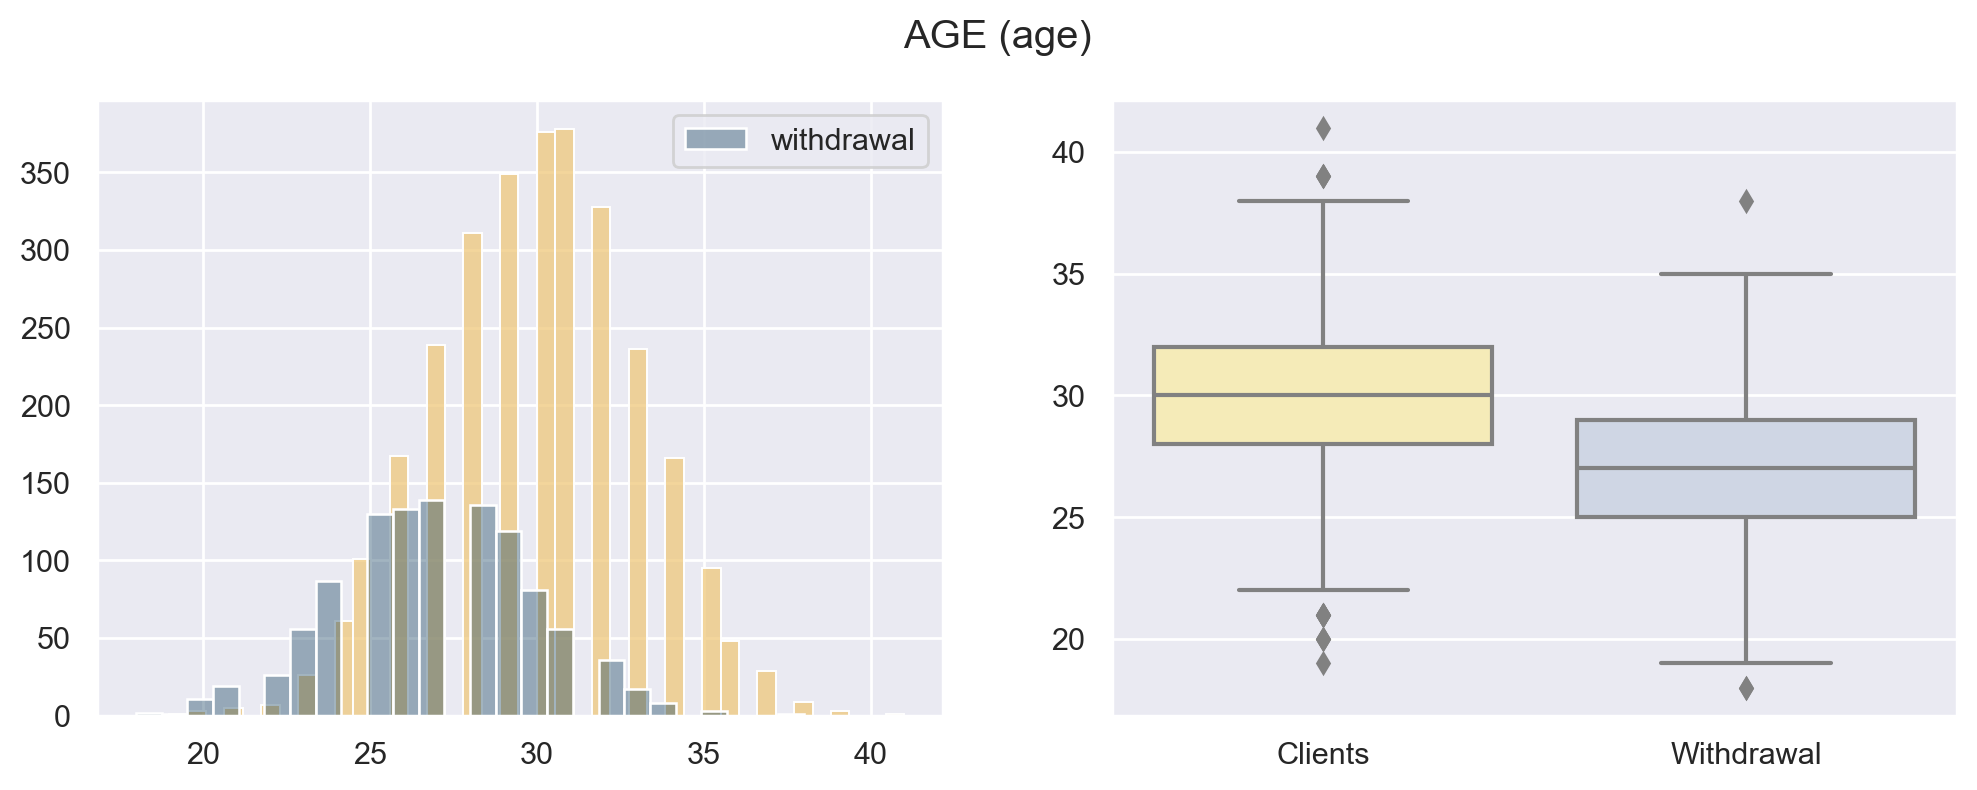

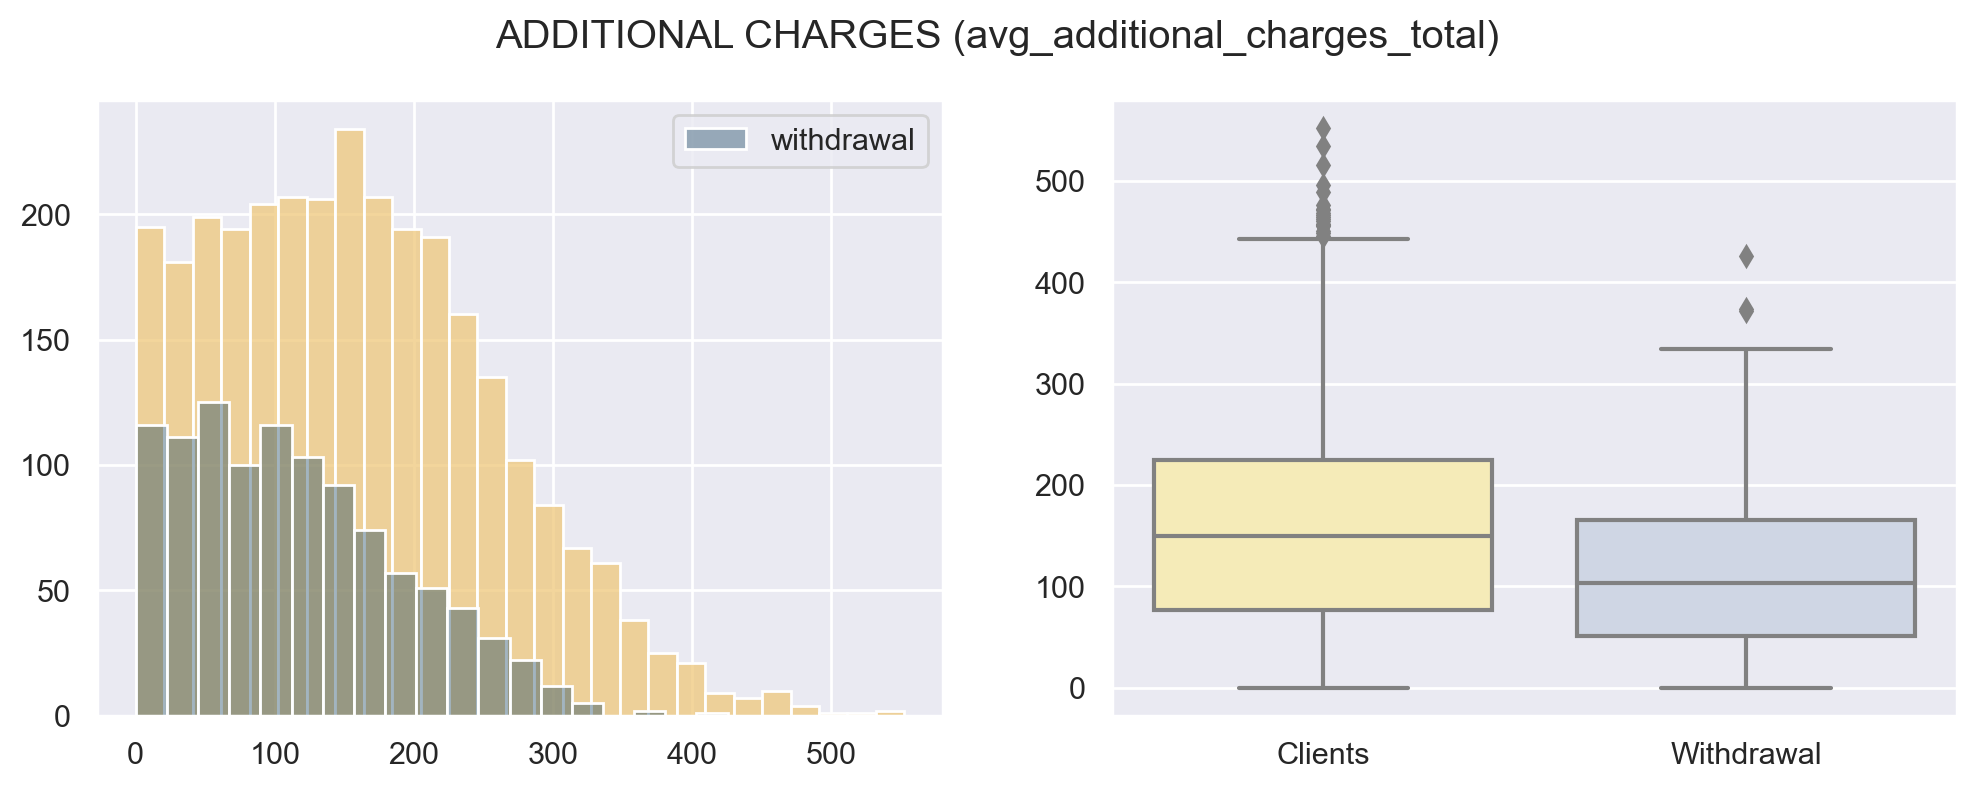

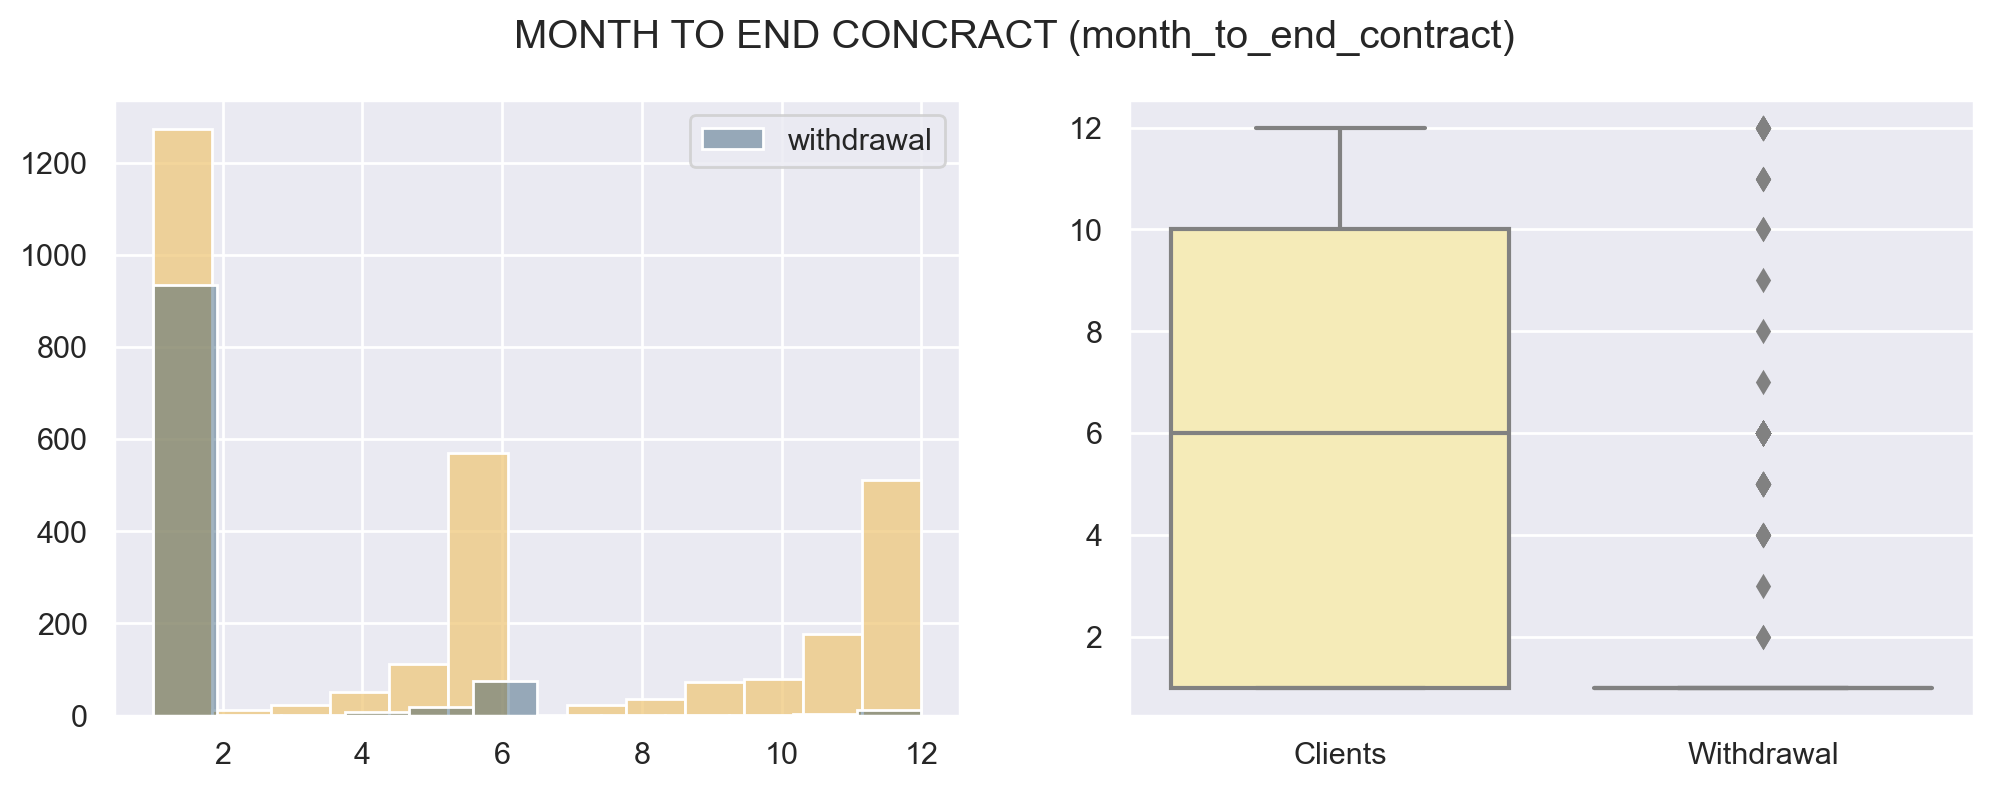

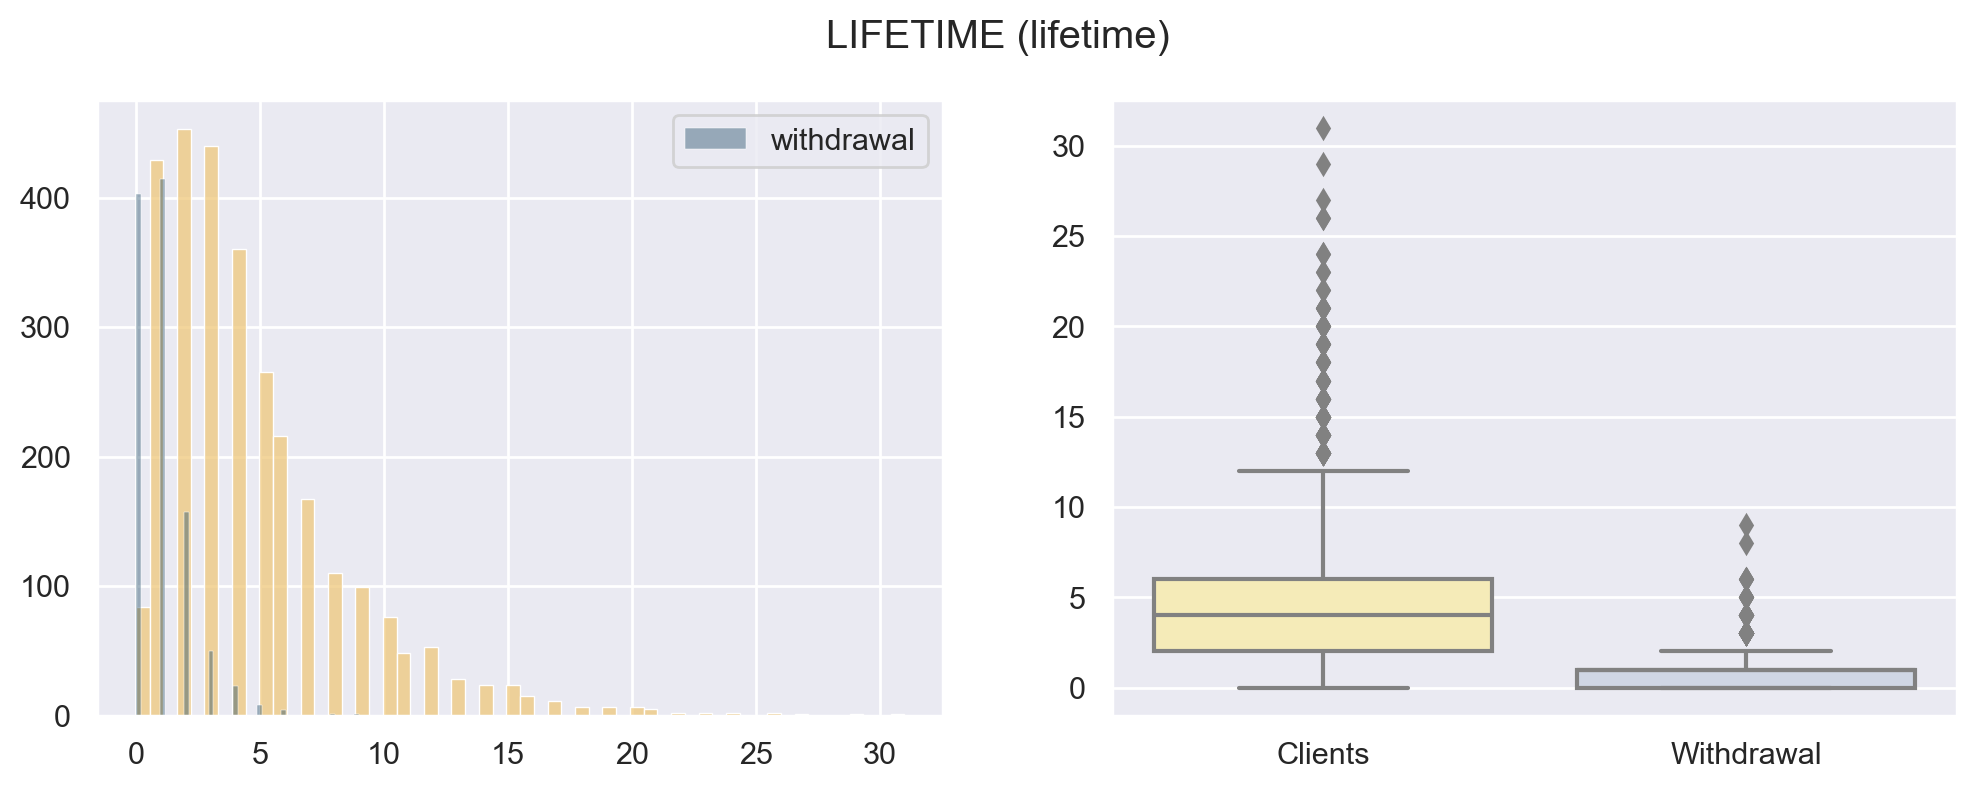

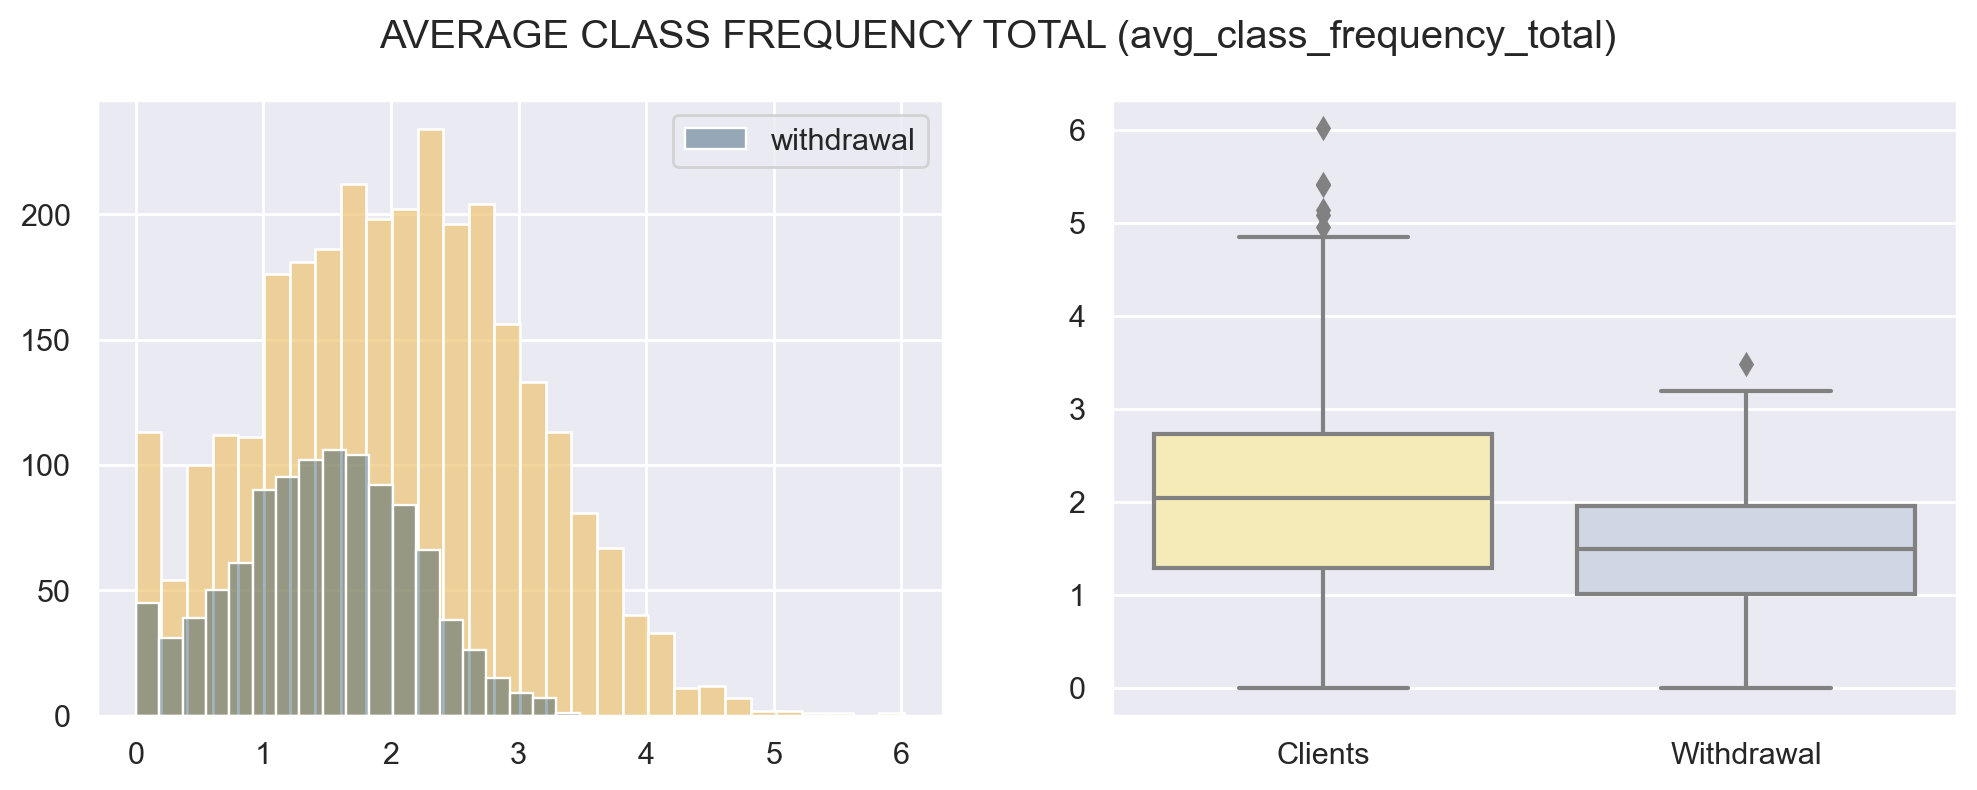

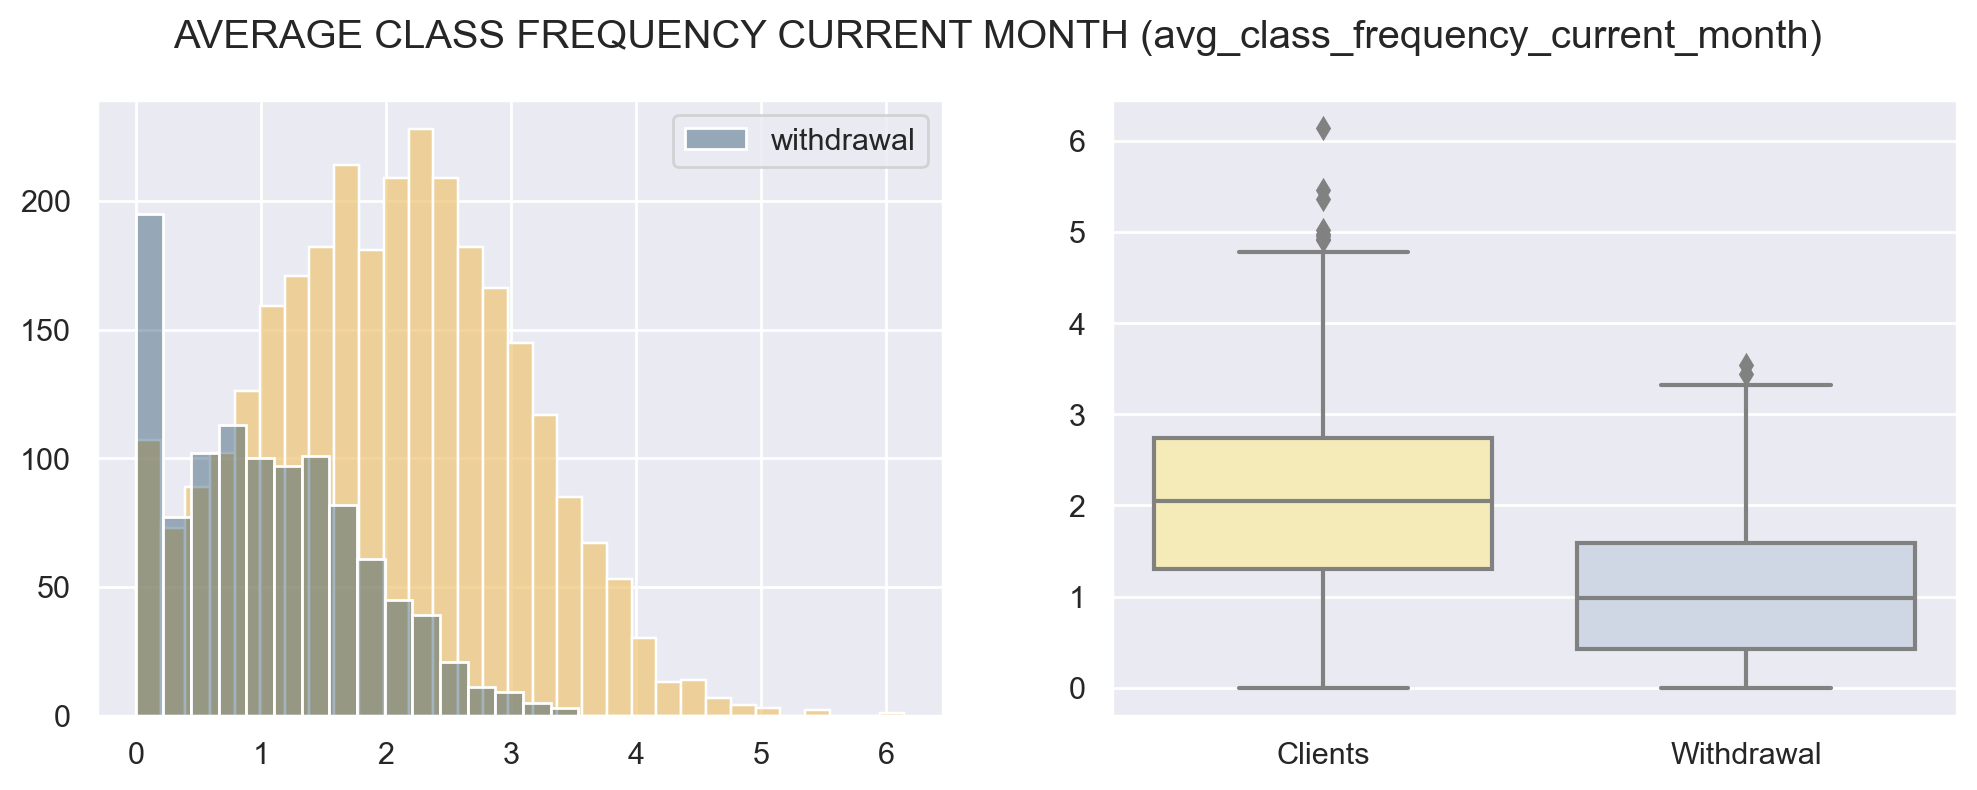

In [12]:
for index, row in numeric.iterrows():
    numeric_plots(data, row[0], row[1])

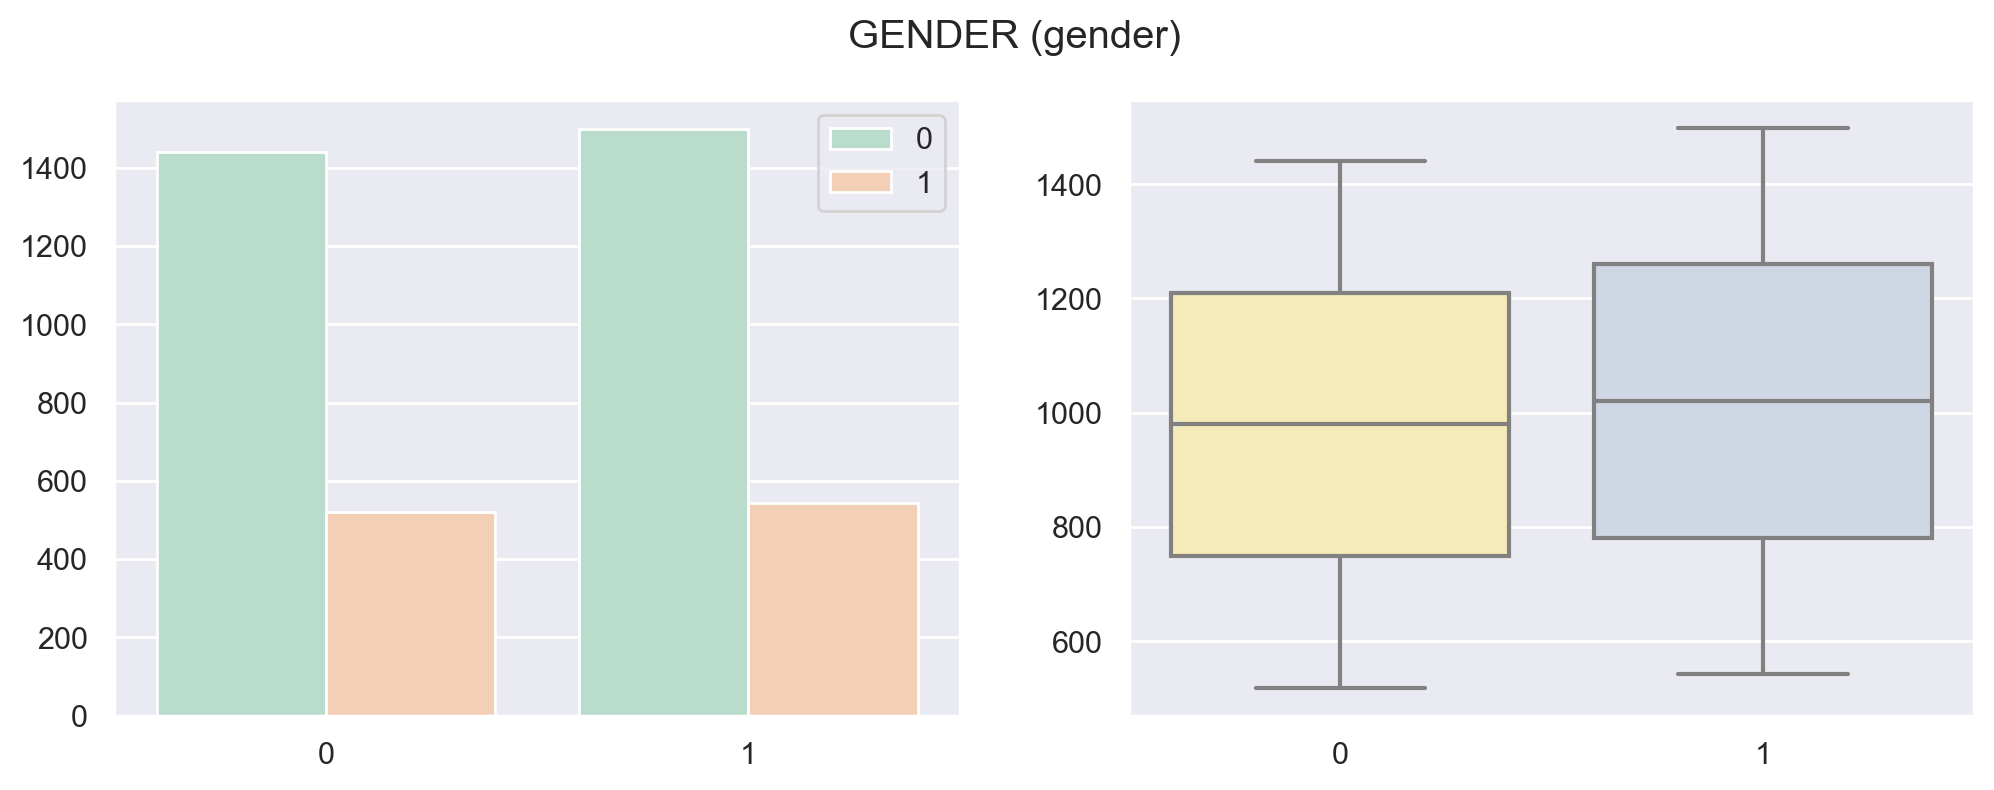

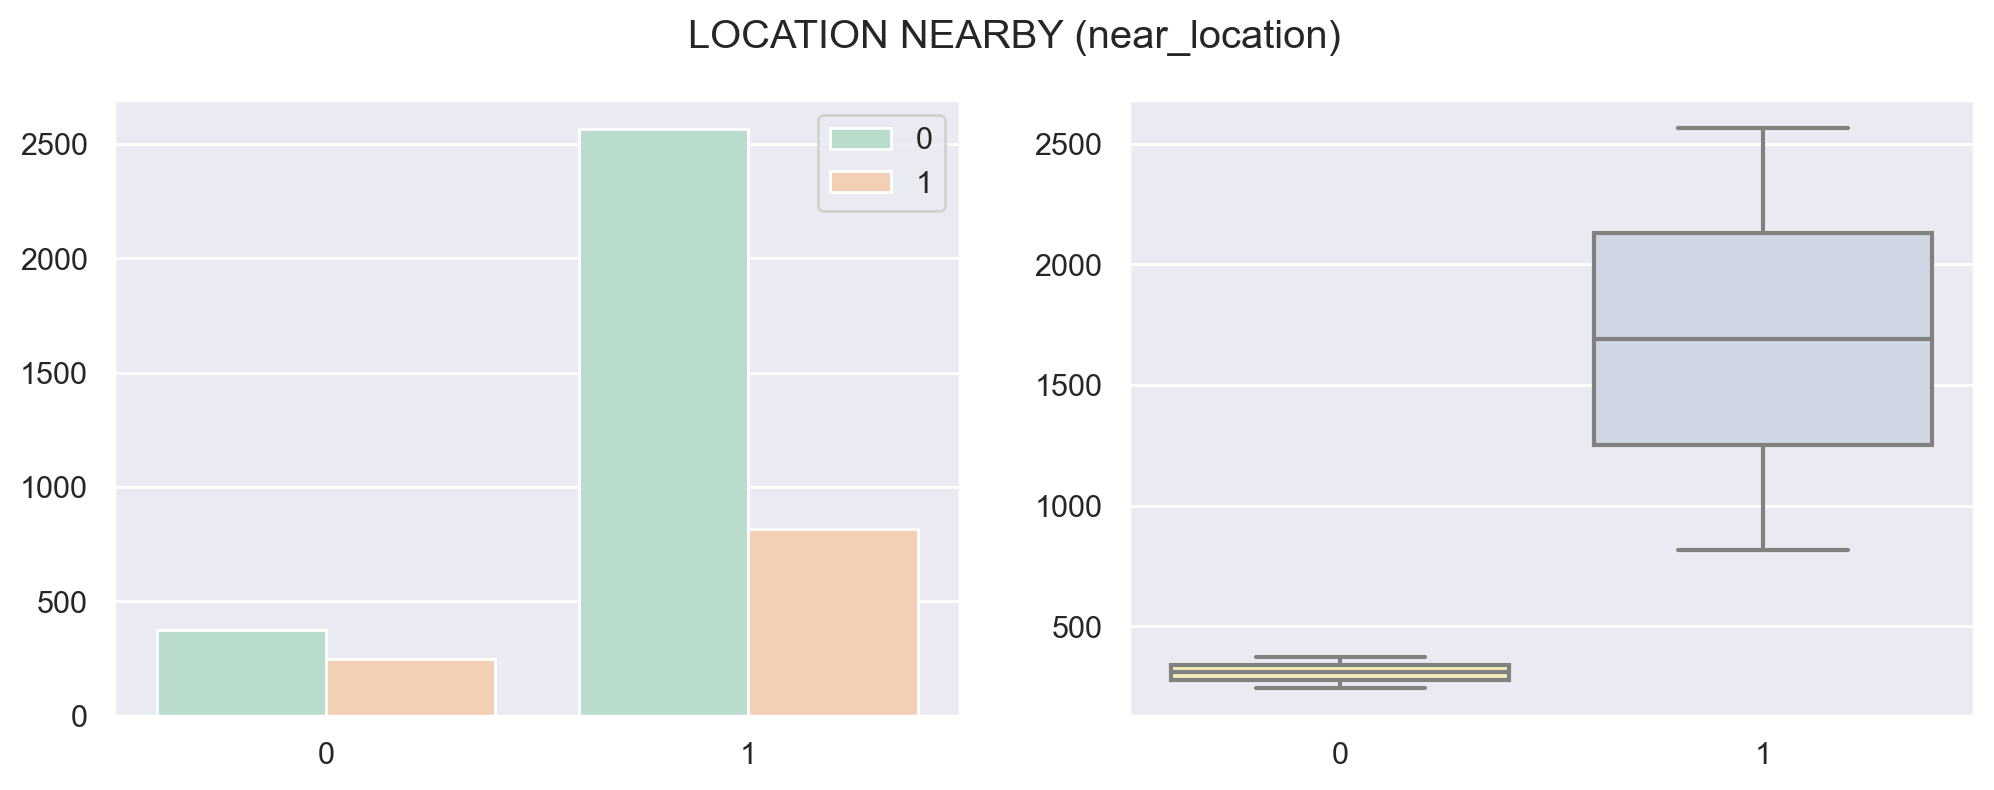

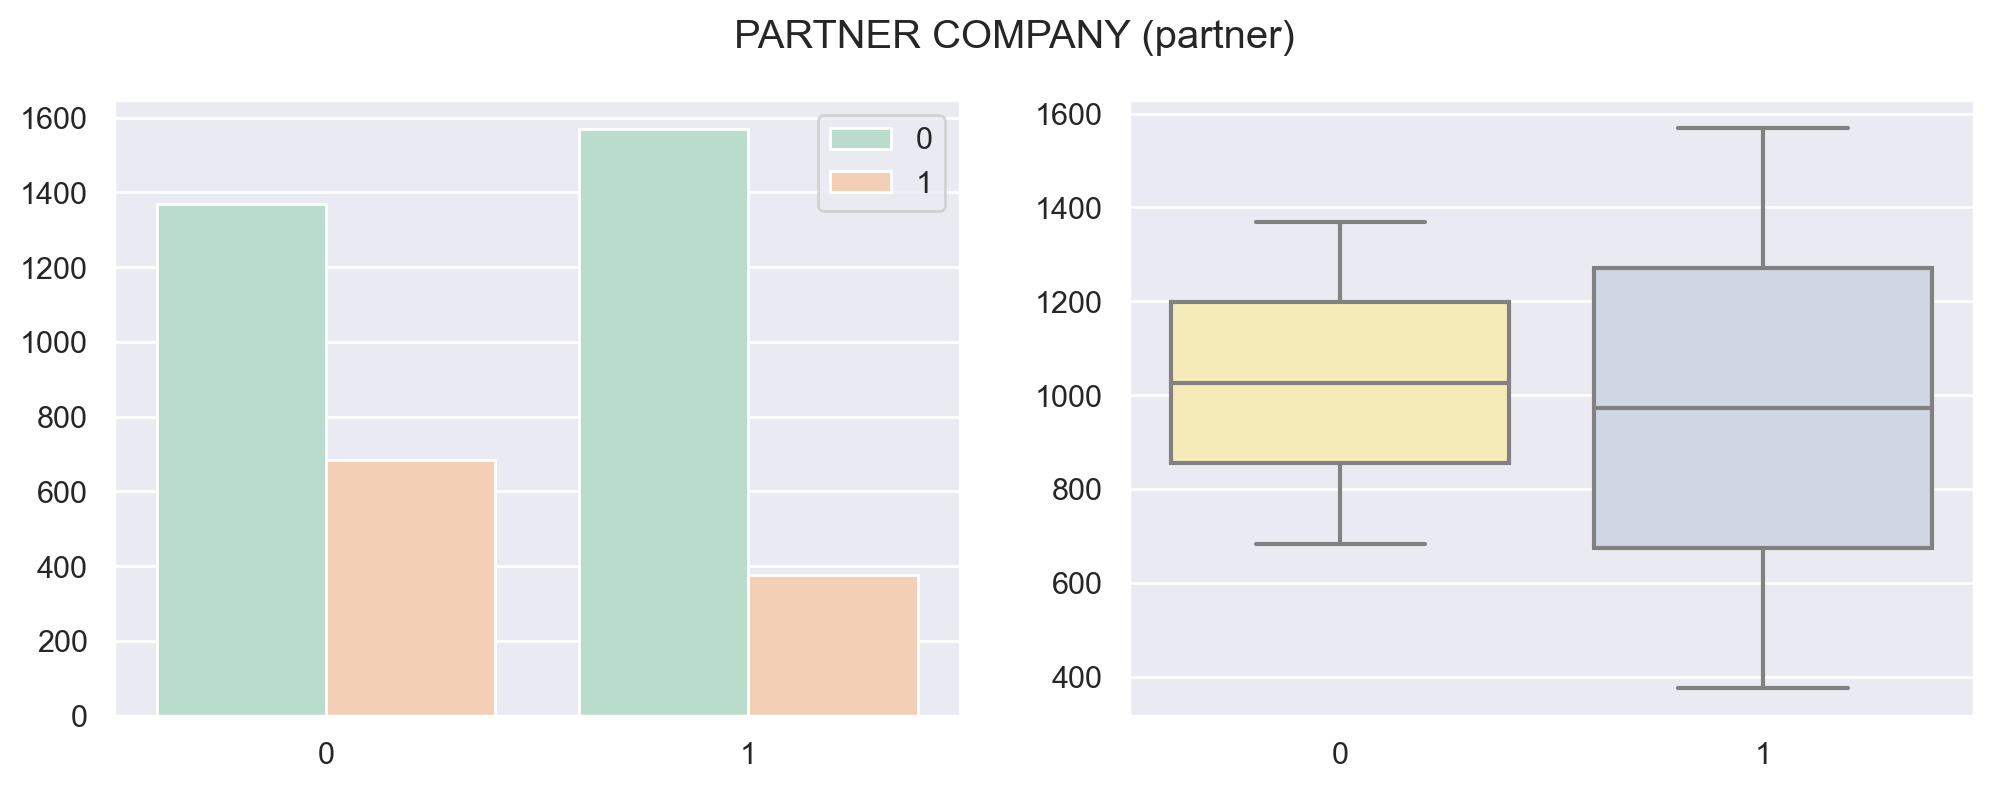

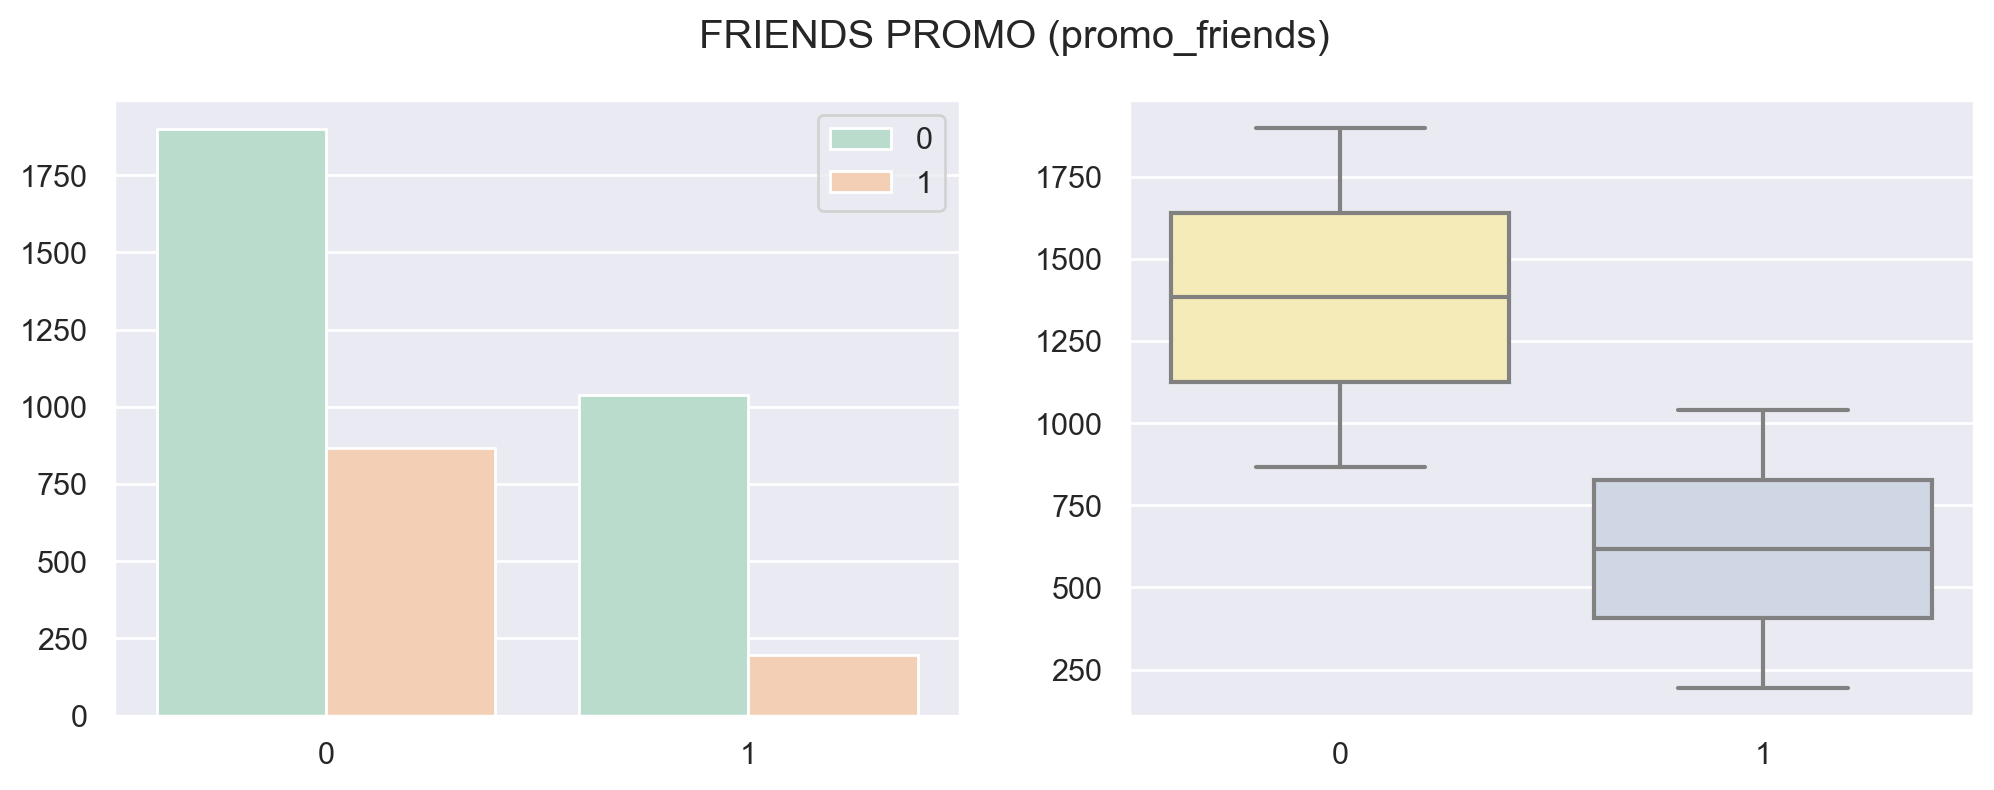

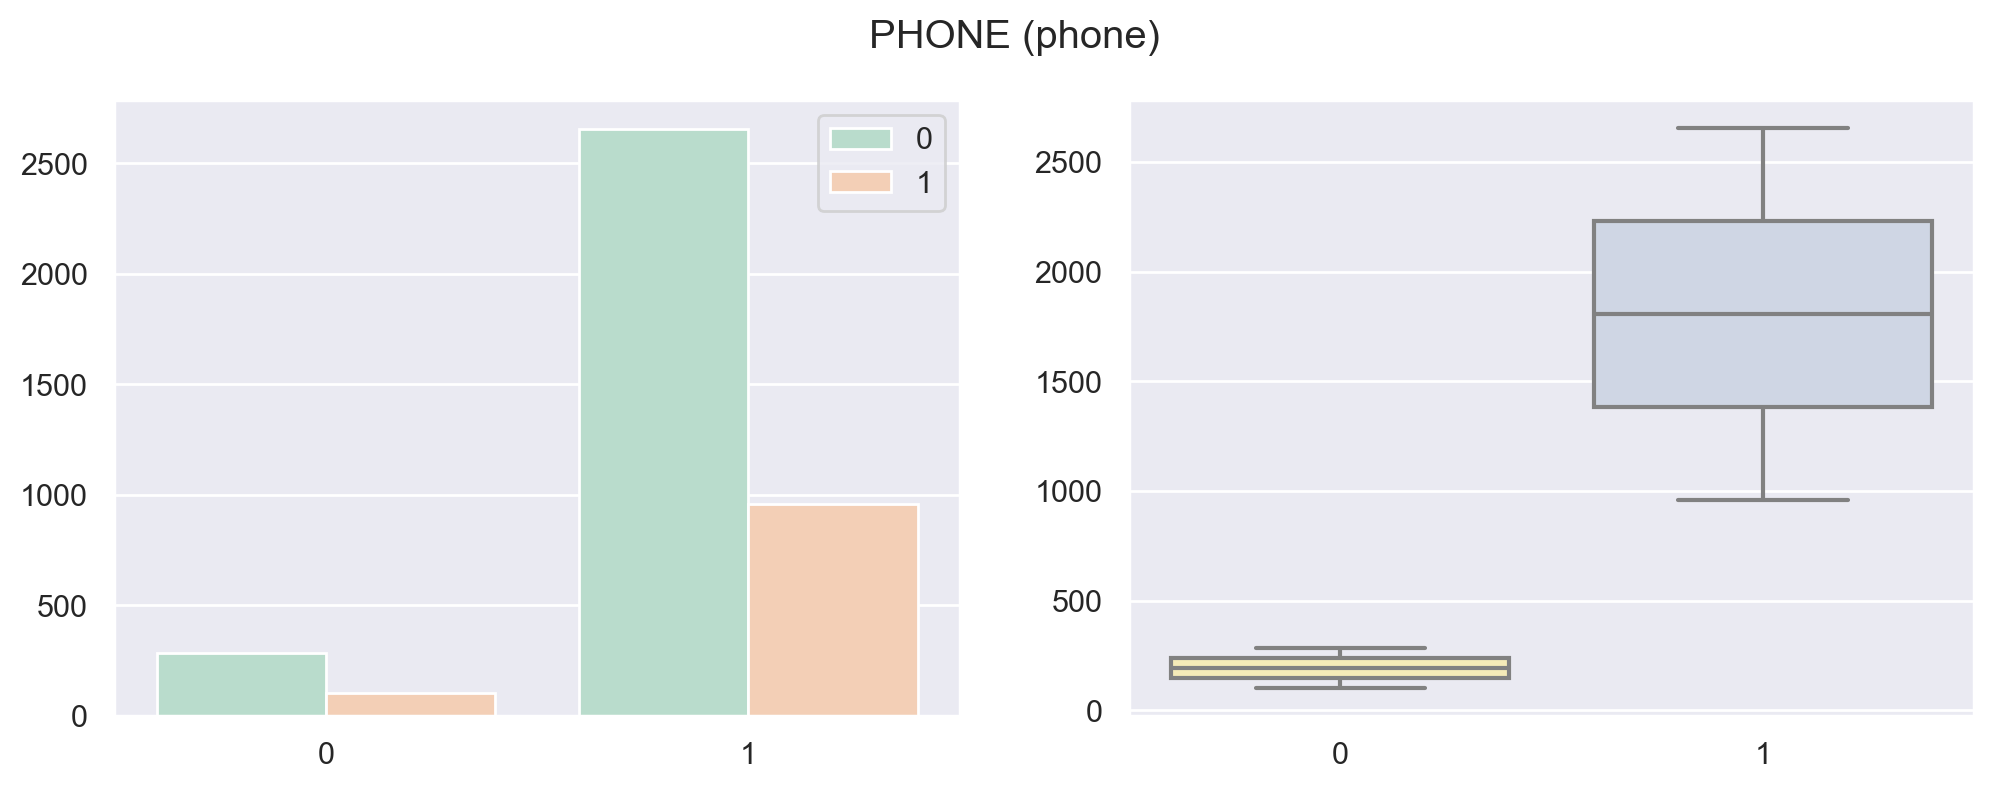

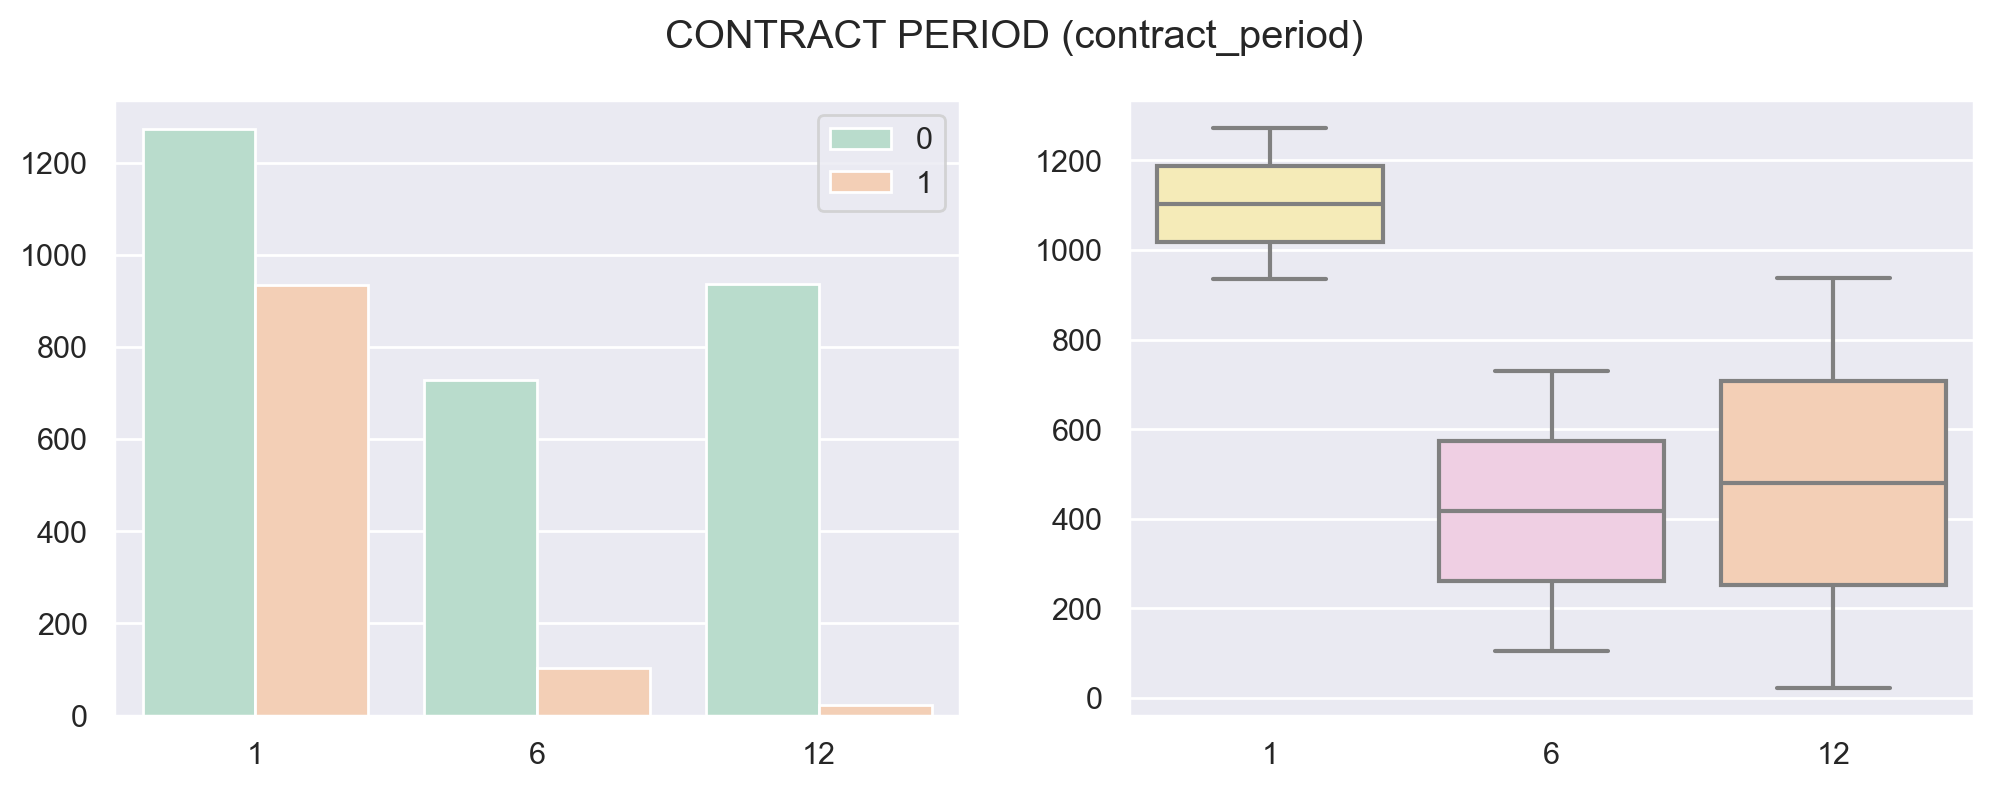

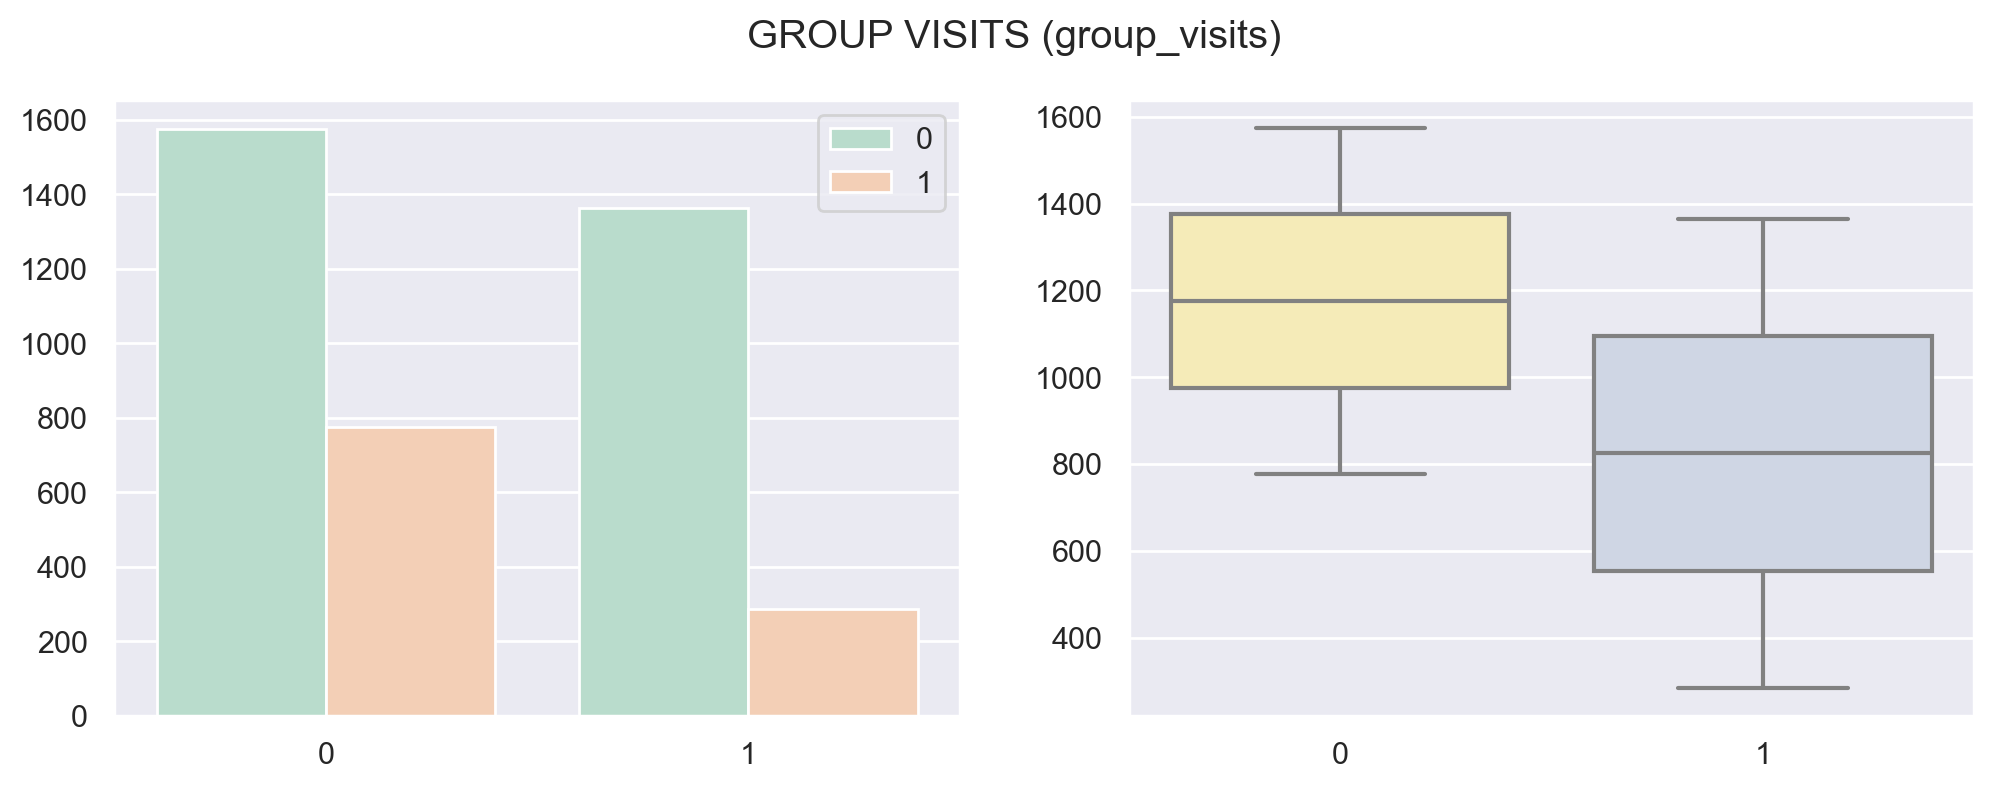

In [13]:
for index, row in categorical.iterrows():
    categorical_plots(data, row[0], row[1])

Conclusions

Withdrawal is not affected by gender and the presence of a phone number.

Withdrawal is definitely influenced by:

- the distance of the fitness center from the place of residence or work;
- discount from the partner company or the "Bring a friend" promotion;
- availability of a subscription for a month (and not for a longer period);
- individual visits, instead of group sessions.

### Correlation Matrix

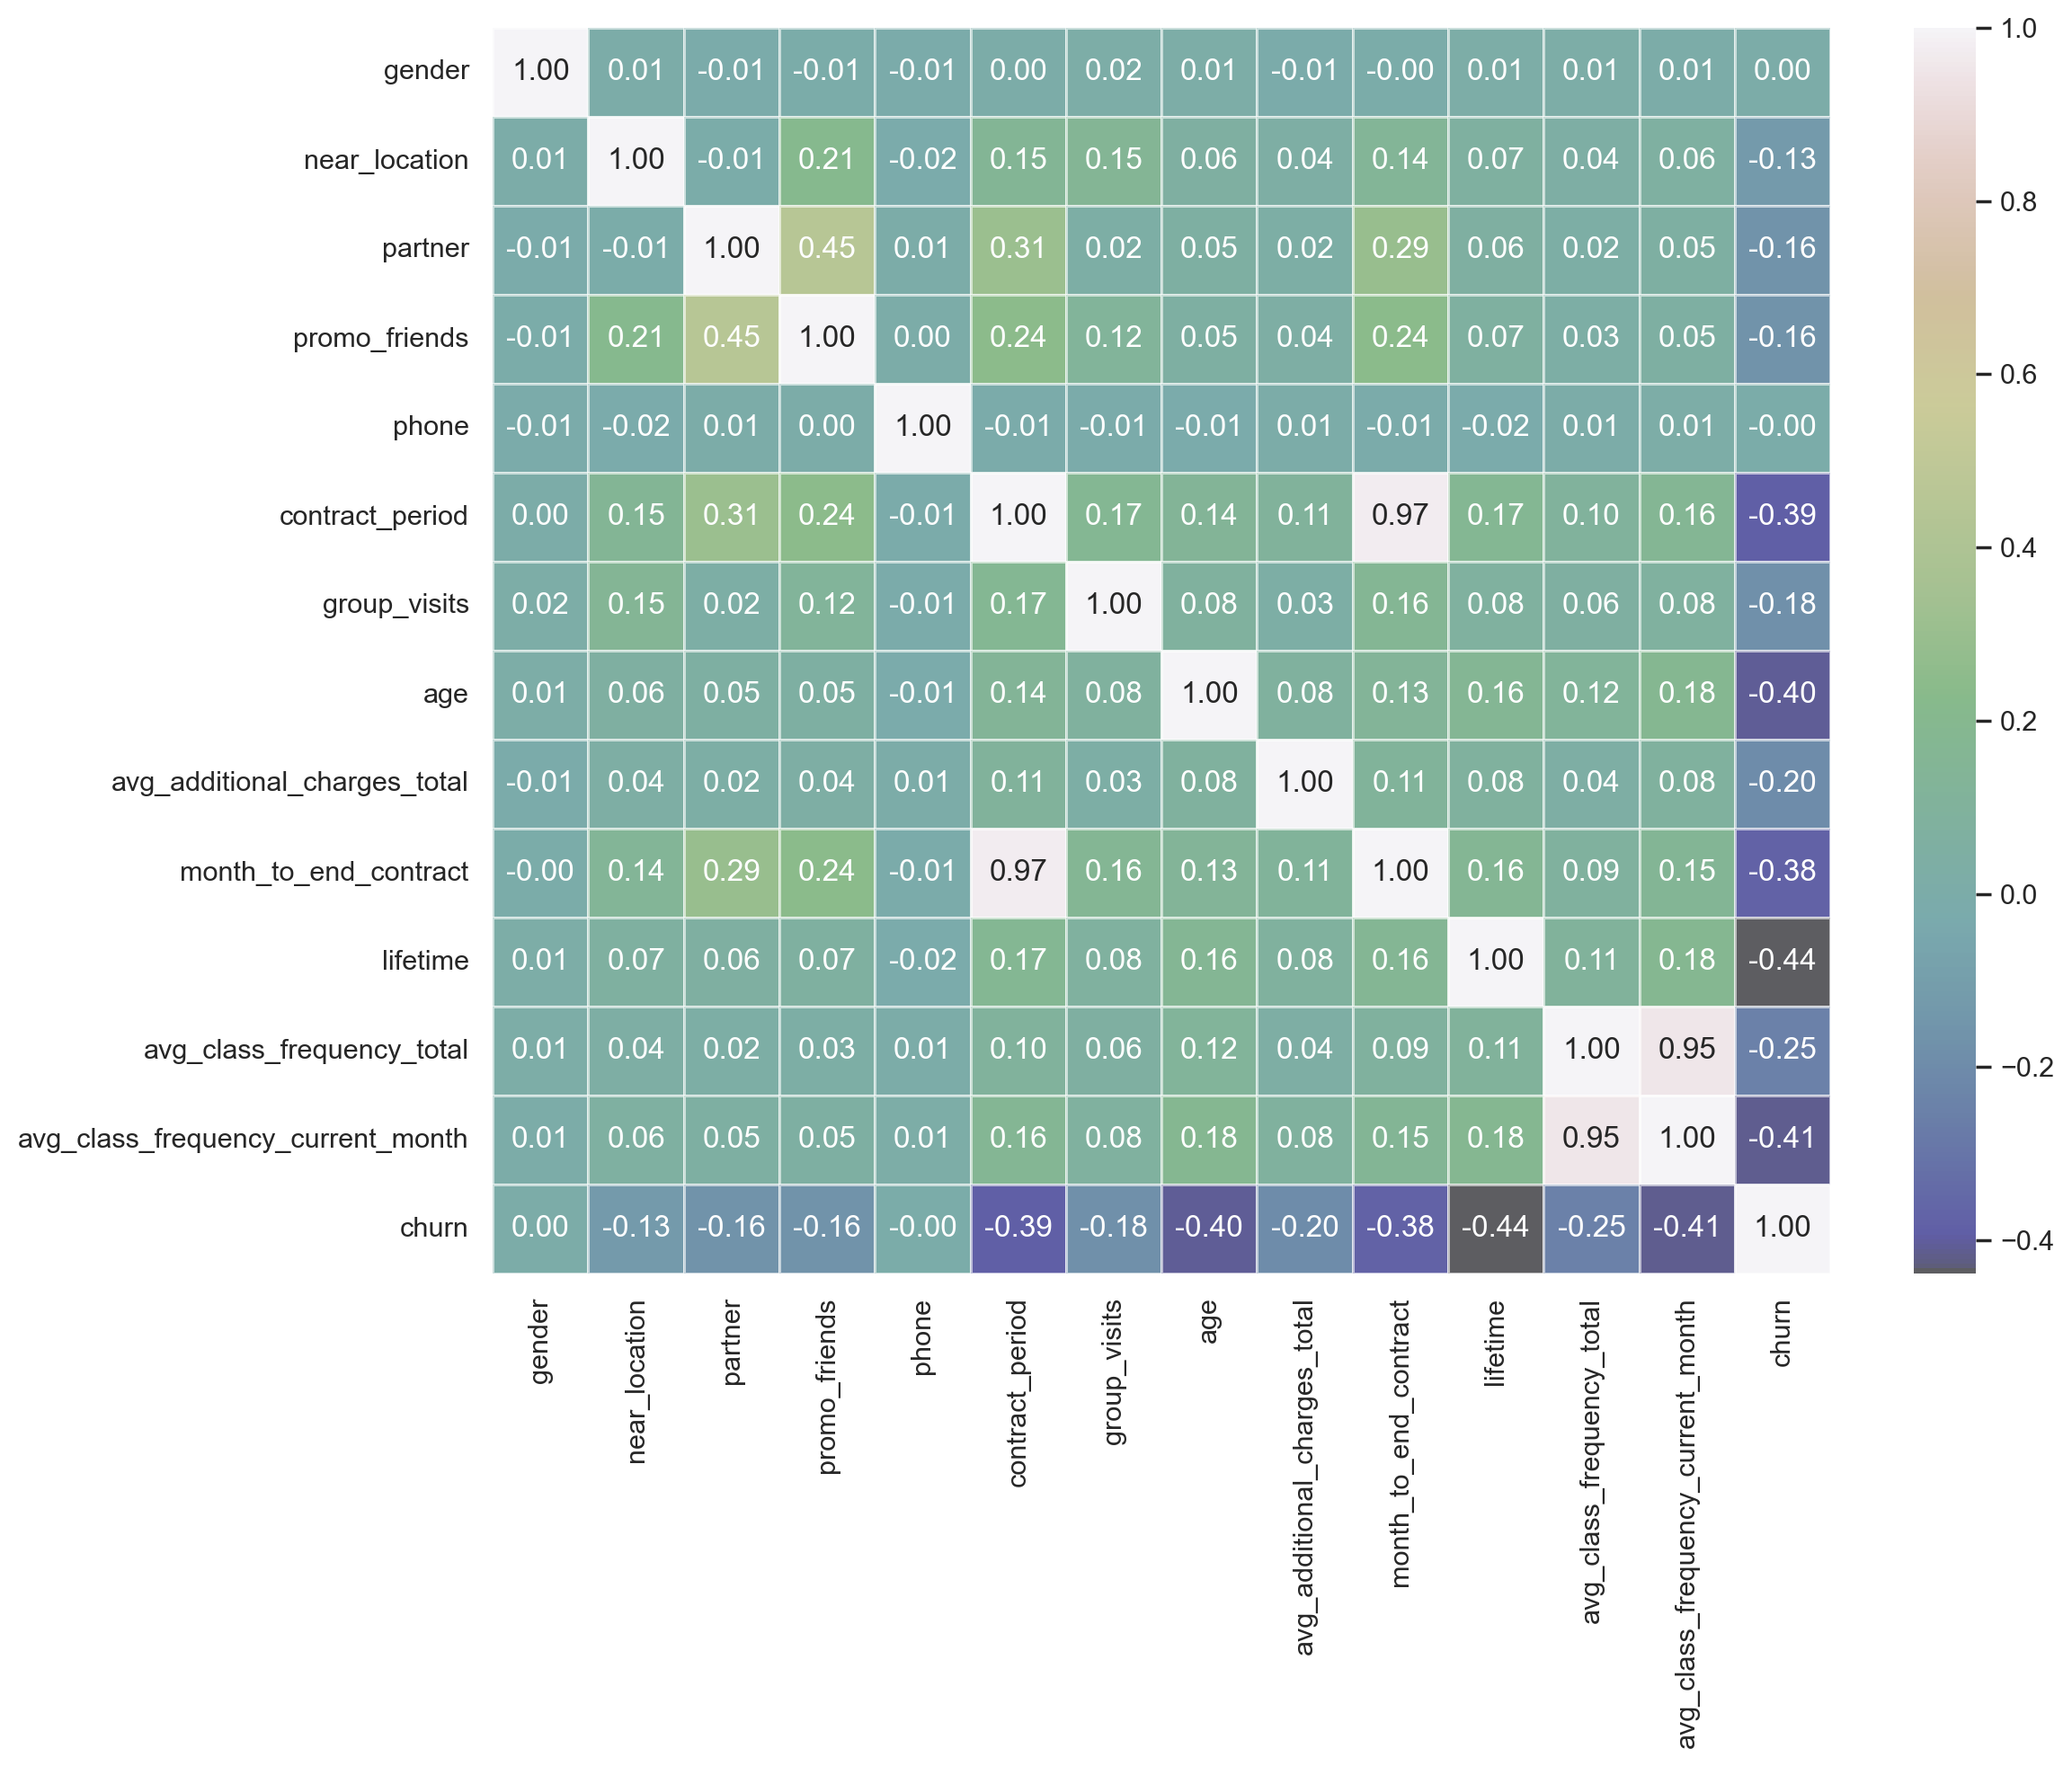

In [14]:
f, ax = plt.subplots(figsize=(12, 9))

sns.heatmap(data.corr(), annot=True, linewidths=.5, ax=ax, cmap='gist_earth',fmt = '0.2f', alpha=.6)
plt.show()


**Conclusions**

There are no signs strongly affecting the withdrawal on the heat map.

Lifetime correlates more than the other characteristics with the target variable.

Next in the level of correlation are average frequency of visits of the last month, age, the term of the current subscription and the number of months before the expiration of the subscription.

Gender and the presence of  phone number in the data do not correlate have nothing to do with withdrawal.

Two pairs of signs obviously strongly correlate with each other:

- subscription period (contract_period) and number of months until the end of the subscription (month_to_end_contract)
- average frequency of visits for the entire period (avg_class_frequency_total) and average frequency of visits for the last month (avg_class_frequency_current_month).

## Customer churn prediction model

Preparing the data: removing outliers (they were clearly visible on the boxplot) by the 99th percentile.

In [15]:
print('Initial number of rows:', len(data))

for col in numeric['col']:
    data = data[data[col] <= np.percentile(data[col], 99)]

print('Number of raws after cleaning:', len(data))

Initial number of rows: 4000
Number of raws after cleaning: 3831


Removing phone and gender columns as they don't correlate with target variable.

In [16]:
data = data.drop(['phone', 'gender'], axis=1)

Let's build a model of binary classification of clients, where the target attribute is the fact of client withdrawal in the next month. Let's split the data into training and validation samples with the train_test_split() function.

Let's train the model on a train sample in two ways:

logistic regression,
random forest.
Let's evaluate the accuracy, precision, recall and F1-score metrics for both models on a validation sample. Let's compare the models and see which model performed better based on metrics.

In [17]:
# function for output of metrics;
# input: the validation value, the predicted value and the name of the metric;

def metrics(y_test, predictions, title):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_test, predictions)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_test, predictions)))
    print('\tRecall: {:.2f}'.format(recall_score(y_test, predictions)))
    print('\tF1-score (summary): {:.2f}'.format(f1_score(y_test, predictions)))

In [18]:
# dividing data into features matrix (matrix X) and target variable (y)
X = data.drop('churn', axis=1)
y = data['churn']

# dividing into training and validation sample
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)

### Logistic regression

In [19]:
# defining an algorithm for our model
lr_model = LogisticRegression(solver='liblinear')

# model training
lr_model.fit(X_train, y_train)

# using model for prediction:
lr_predictions = lr_model.predict(X_test)

### Random forest

In [20]:
# training StandartScaler on a training sample:
scaler = StandardScaler()
scaler.fit(X_train)

# transforming the training and validation data sets:
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

# defining an algorithm for the model based on the random forest algorithm:
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0)

# training random forest model:
rf_model.fit(X_train_st, y_train)

# using model for prediction:
rf_predictions = rf_model.predict(X_test_st)

### Results

In [21]:
# results:

metrics(y_test, lr_predictions, 'Logic regression score:')
metrics(y_test, rf_predictions, title = 'Random forest score:')

Logic regression score:
	Accuracy: 0.92
	Precision: 0.86
	Recall: 0.86
	F1-score (summary): 0.86
Random forest score:
	Accuracy: 0.92
	Precision: 0.85
	Recall: 0.85
	F1-score (summary): 0.85


It is observed that the metrics are practically the same, but the logistic regression model in our case showed slightly better results.

After fitting the model, the coefficients are stored in the coef_ property.

The following fragment trains a logistic regression model, creates a data frame in which features with corresponding coefficients are stored, and sorts this data frame by coefficient in descending order.

In [22]:
# algorithm for model
flr_model = LogisticRegression(solver='liblinear')

# training model
flr_model.fit(X_train, y_train)

# using model for prediction:
importances = pd.DataFrame(data={
    'attribute': X_train.columns,
    'importance': flr_model.coef_[0]
})
importances = importances.sort_values(by='importance', ascending=False)
importances

,attribute,importance
9,avg_class_frequency_total,3.33
0,near_location,0.09
1,partner,0.07
6,avg_additional_charges_total,-0.00
7,month_to_end_contract,-0.02
5,age,-0.19
3,contract_period,-0.26
2,promo_friends,-0.60
4,group_visits,-0.73
8,lifetime,-0.97


### Clusterization of clients

Conducting clustering of clients: building distance matrix with the linkage() function on a standardized feature matrix and drawing dendrogram.

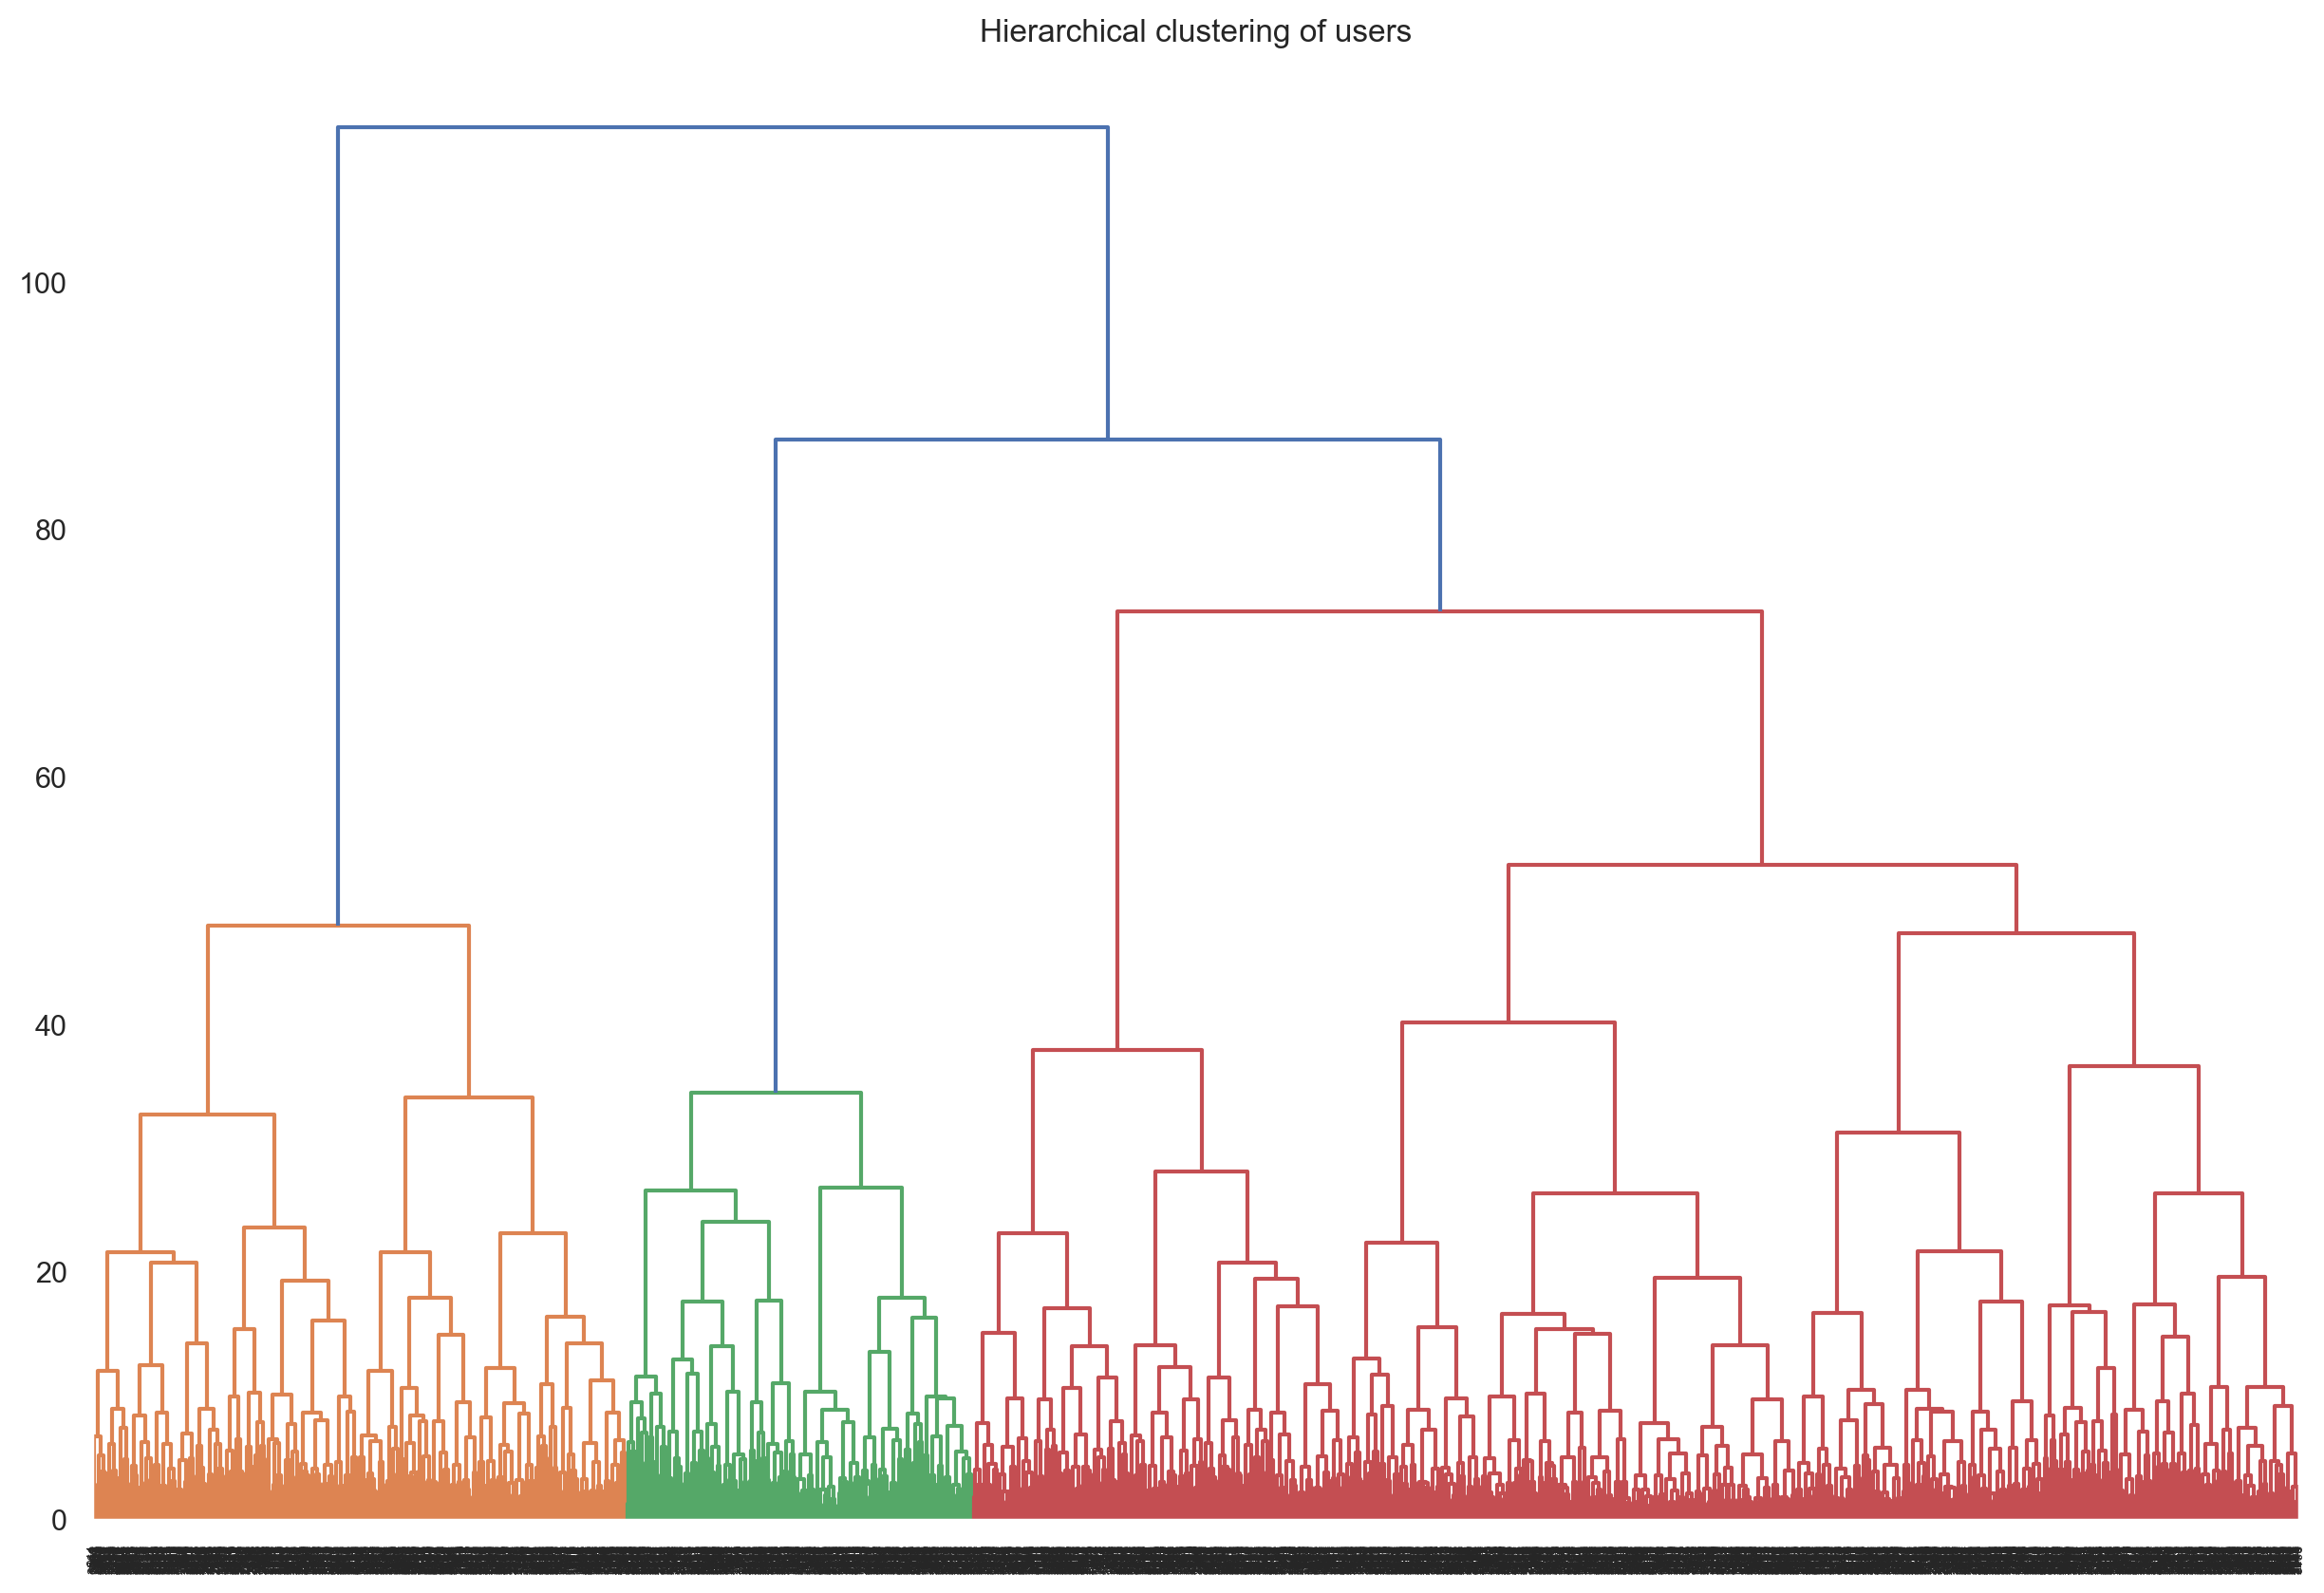

In [23]:
# data for clusterization:
x = data.drop('churn', axis = 1)

# mandatory standartization
sc = StandardScaler()
x_sc = sc.fit_transform(x)

# buildingtable of distances between objects:
linked = linkage(x_sc, method = 'ward')

# vizualization:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Hierarchical clustering of users')
plt.show()

On the dendrogram we see three colors, the red area turned out to be clearly larger than the others, let's try to split the data into 5 clusters for more detail.

Let's train a clustering model based on the K-Means algorithm.

In [24]:
# k_means model with  5 clusters and fixed value of random_state
km = KMeans(n_clusters=5, random_state=0) 

# appling algorithm to data and form vector of clusters (the algorithm assigns them numbers from 0 to 4))
labels = km.fit_predict(x_sc)

# saving cluster metrics in dataset
data['cluster_km'] = labels

# statistics grouped by cluster
display(data.groupby('cluster_km').mean().T)

# cluster size
print('cluster size:')
display(data.cluster_km.value_counts())

# silhoutte score:
print('Silhouette_score : {:.2f}'.format(silhouette_score(x_sc, labels)))

cluster_km,0,1,2,3,4
near_location,1.00,0.98,0.94,0.00,1.00
partner,0.84,0.23,0.74,0.47,0.25
promo_friends,1.00,0.06,0.49,0.08,0.03
contract_period,3.16,2.64,11.87,2.17,1.94
group_visits,0.45,0.46,0.55,0.21,0.32
age,29.21,30.02,29.88,28.45,28.10
avg_additional_charges_total,141.23,155.40,160.59,129.77,127.42
month_to_end_contract,2.92,2.44,10.88,2.04,1.87
lifetime,3.50,4.83,4.52,2.60,2.18
avg_class_frequency_total,1.77,2.63,1.98,1.65,1.21


cluster size:


4    1008
2     900
1     764
0     629
3     530
Name: cluster_km, dtype: int64

Silhouette_score : 0.15


The value of the silhouette score is not very high. Unfortunately, it is rarely possible to find a clear division into groups , so it is advisable to discuss the result of the assessment with experts.

The most reliable cluster No. 2 (2% withdrawal) has relatively high average values for all signs, but is especially distinguished by a long subscription (on average 11.87 months) and the number of months before its end (10.88). At the same time, it should be noted that the life cycle of such clients is also high. It can be assumed that these customers first bought monthly subscriptions, and then - subscriptions for 6 and 12 months.

The second most reliable cluster No. 1 (9% withdrawal) is distinguished by a higher average age of customers (30 years) and the frequency of visits to the club (both for the entire period and for the last month, i.e. there is a characteristic intensity of visits and involvement).

Cluster No. 4 has the highest withdrawal (57%). The clients of this group live or work nearby, but for all other signs, the values are lower than those of the other clusters (age, expenses, visits, life cycle + no discounts).

Another cluster causing anxiety is No. 3 with 46% withdrawal. It is very similar to cluster No. 4, but consists of clients living or working in a department from a fitness club.

### Characteristics by cluster

In [25]:
# function for drawing a distribution histogram and boxplot diagram for numerical features;
# input parameters: dataframe, the name of the column on which we plot the graph, the name of the graph;

def cluster_numeric_plots(df, col, title):
    fig, ax = plt.subplots(figsize = (12, 4))

    for cluster in [df.loc[df['cluster_km'] == i] for i in range(5)]:
        sns.distplot(cluster[col], label = cluster['cluster_km'].unique(),
                     hist=False, ax = plt.subplot(1, 2, 1))
        plt.xlabel('')
        plt.ylabel('')
        plt.legend()

    sns.boxplot(y = df[col], x = df['cluster_km'], ax = plt.subplot(1, 2, 2), palette='Pastel2') 
    plt.xlabel('')
    plt.ylabel('')

    fig.suptitle(title + ' (' + col + ') by cluster')
    plt.show()

In [26]:
# function for drawing bar charts and boxplot charts for categorical features;
# input parameters: dataframe, the name of the column on which we plot the graph, the name of the graph;

def cluster_categorical_plots(df, col, title):
    fig, ax = plt.subplots(figsize = (12, 4))

    sns.countplot(x = 'cluster_km', hue = col, data = df, ax = plt.subplot(1, 2, 1),  palette='Pastel2')
    plt.ylabel('')
    plt.xlabel('')
    plt.legend() 
    
    gr = df.groupby([col, 'cluster_km']).agg(count=('age', 'count')).reset_index()
    sns.boxplot(x = 'cluster_km', y = 'count', data = gr, ax = plt.subplot(1, 2, 2), palette='Pastel2') 
    plt.xlabel('')
    plt.ylabel('')

  
    fig.suptitle(title + ' (' + col + ') by cluster')
    plt.show()

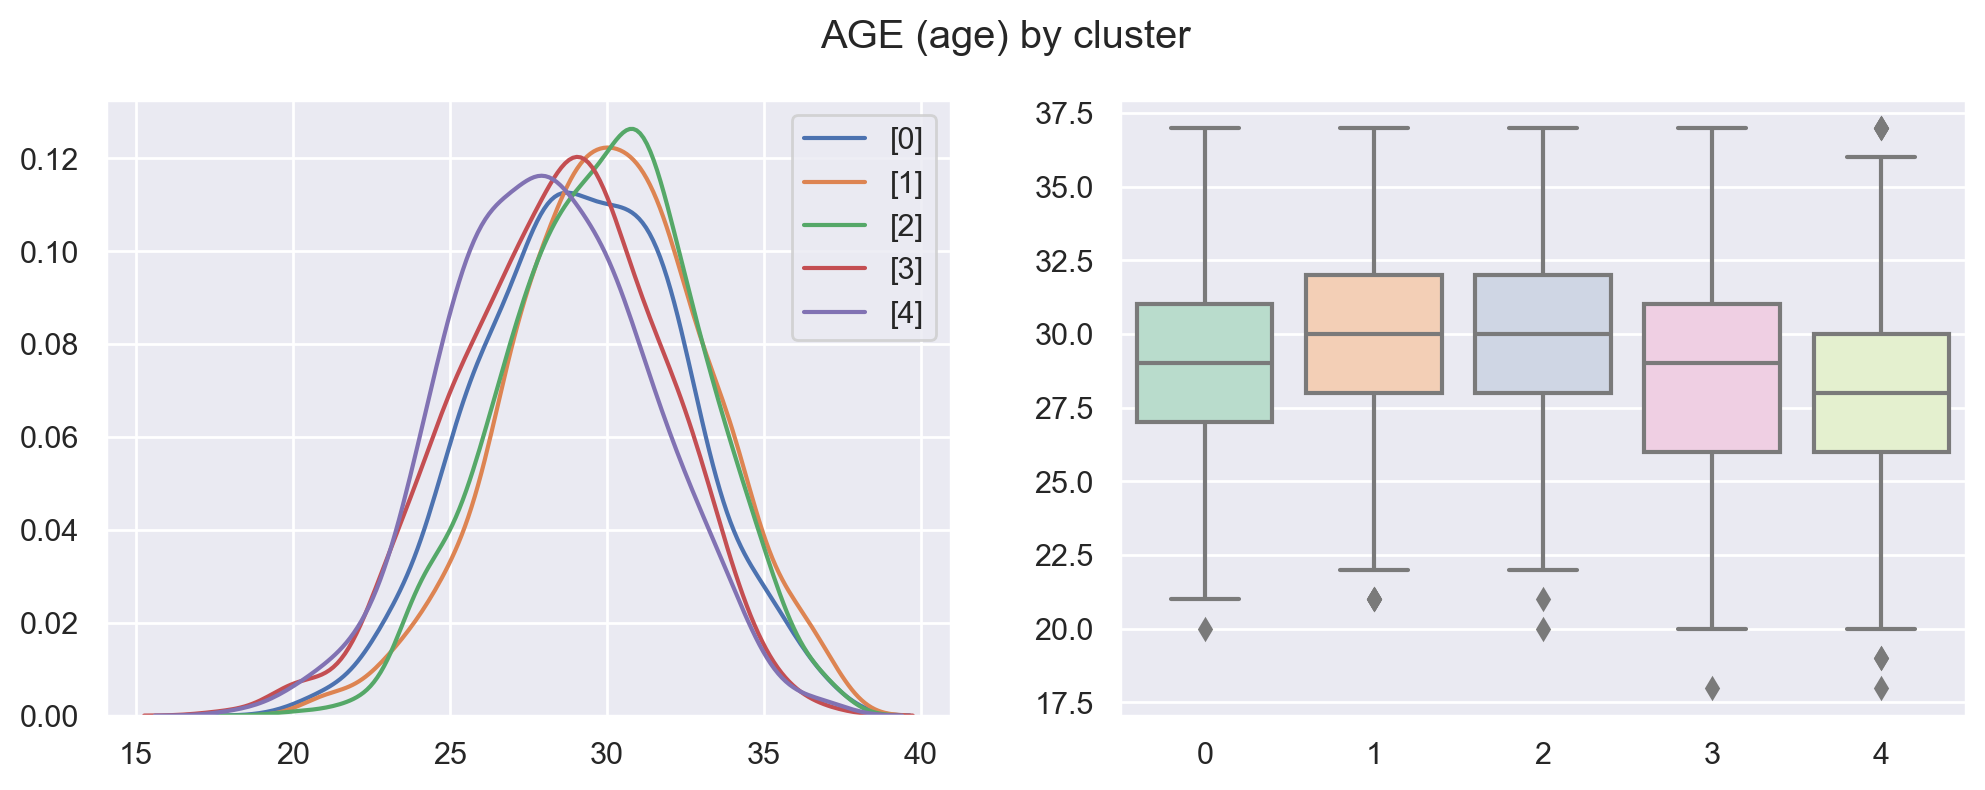

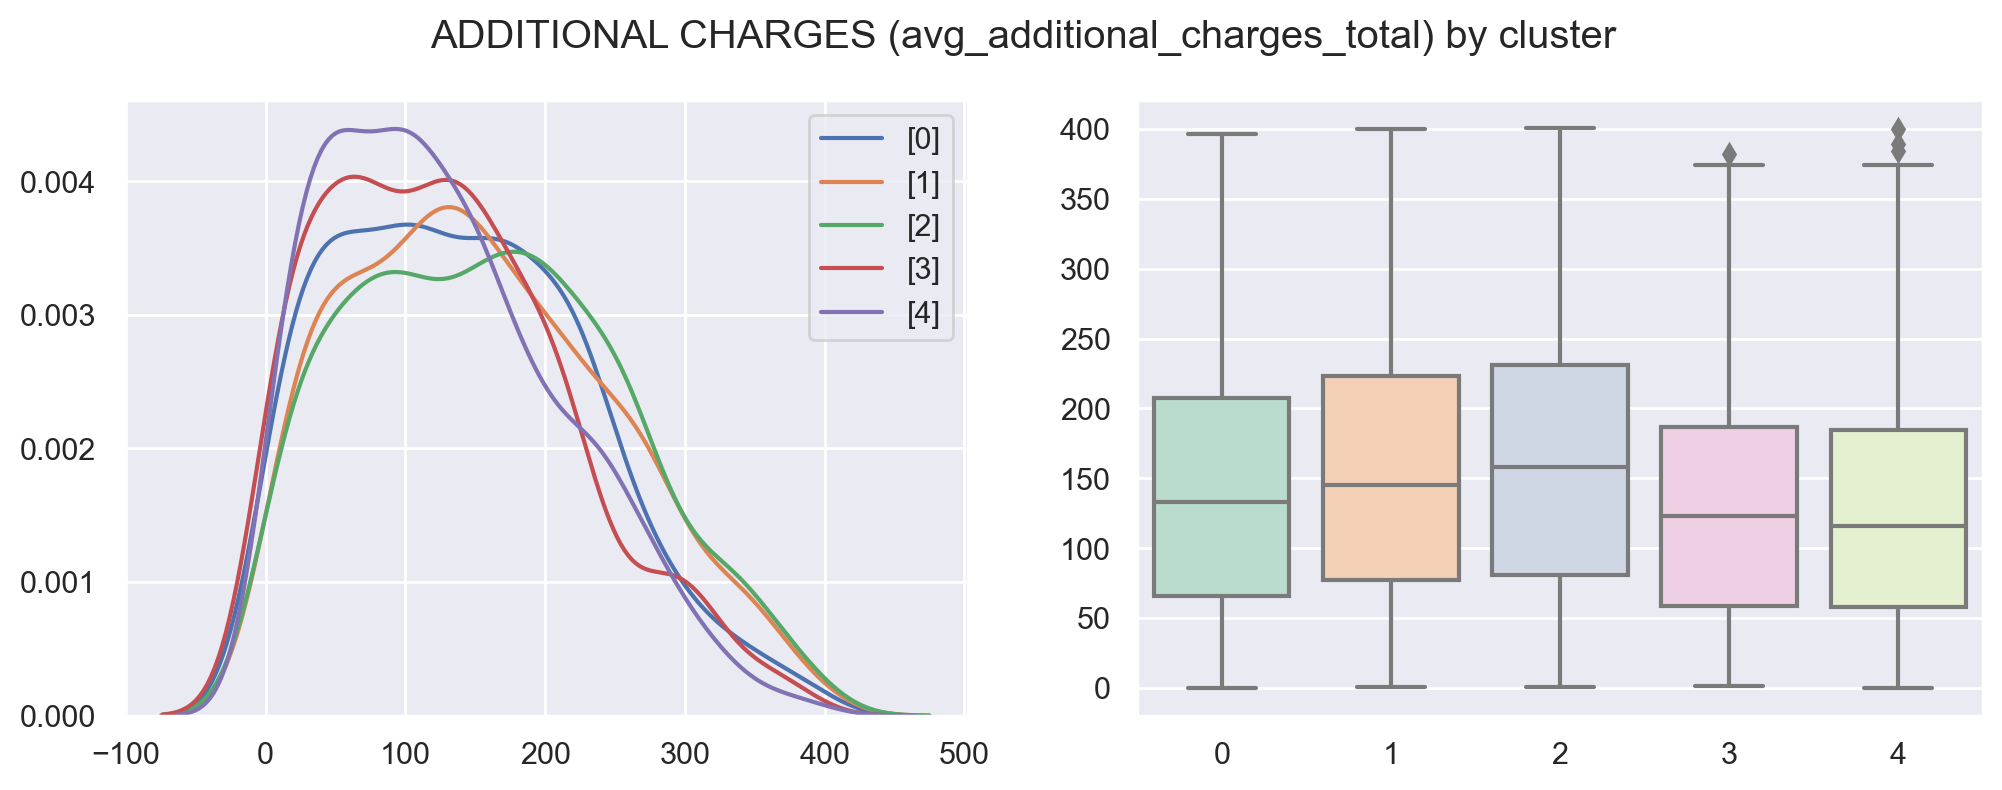

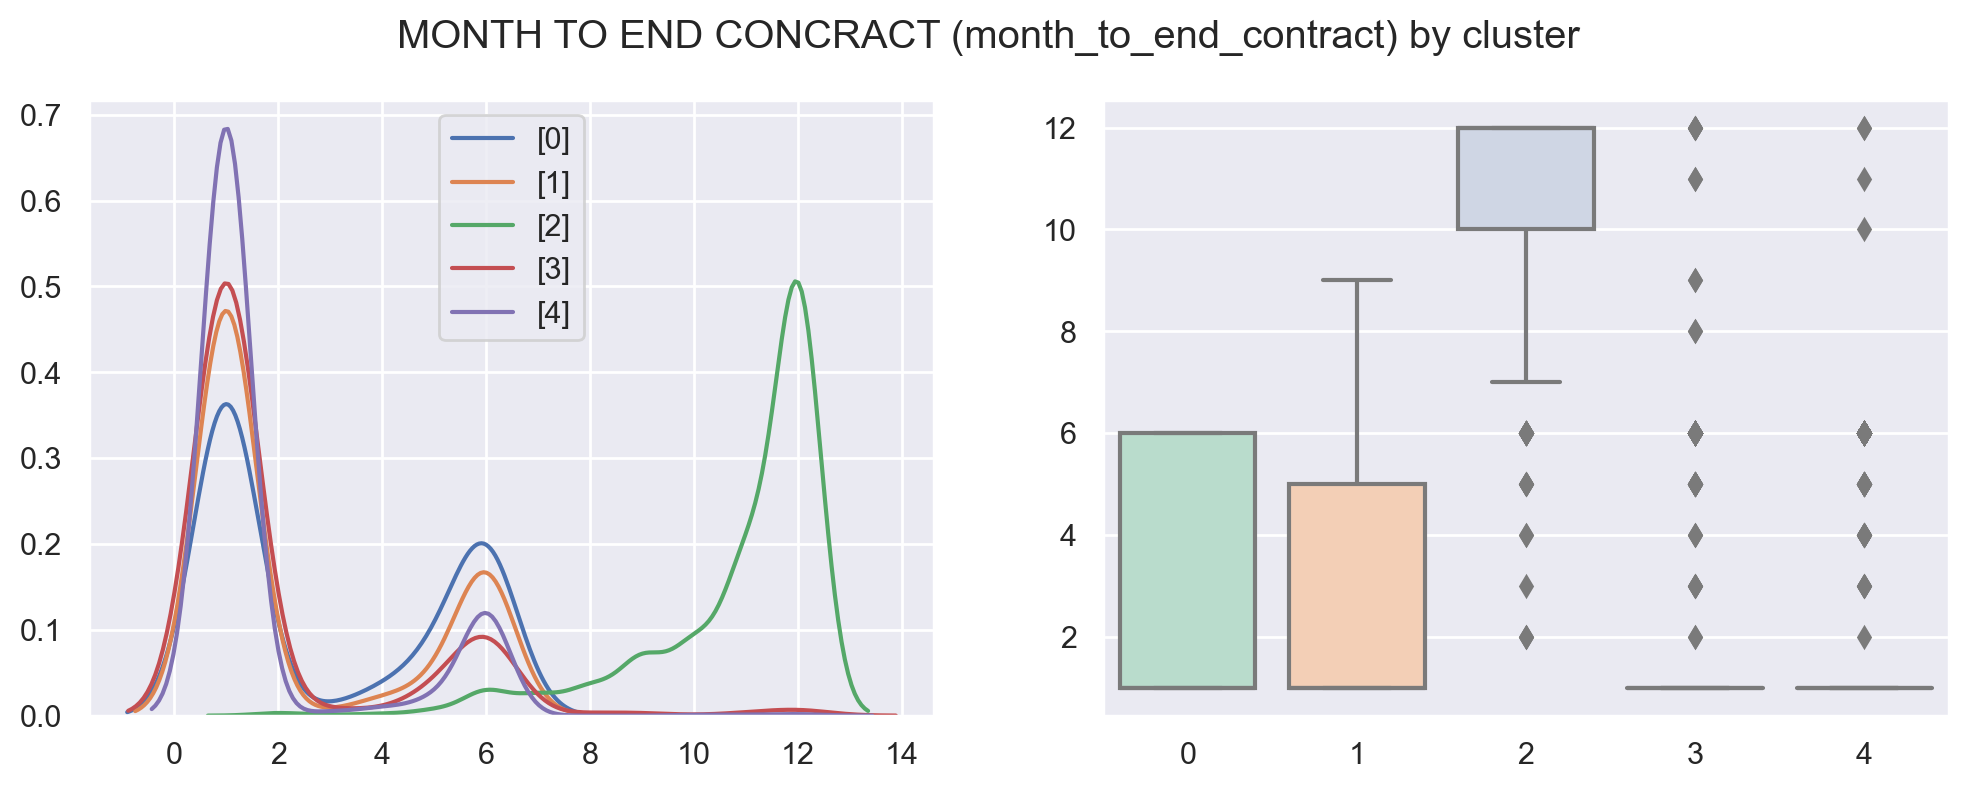

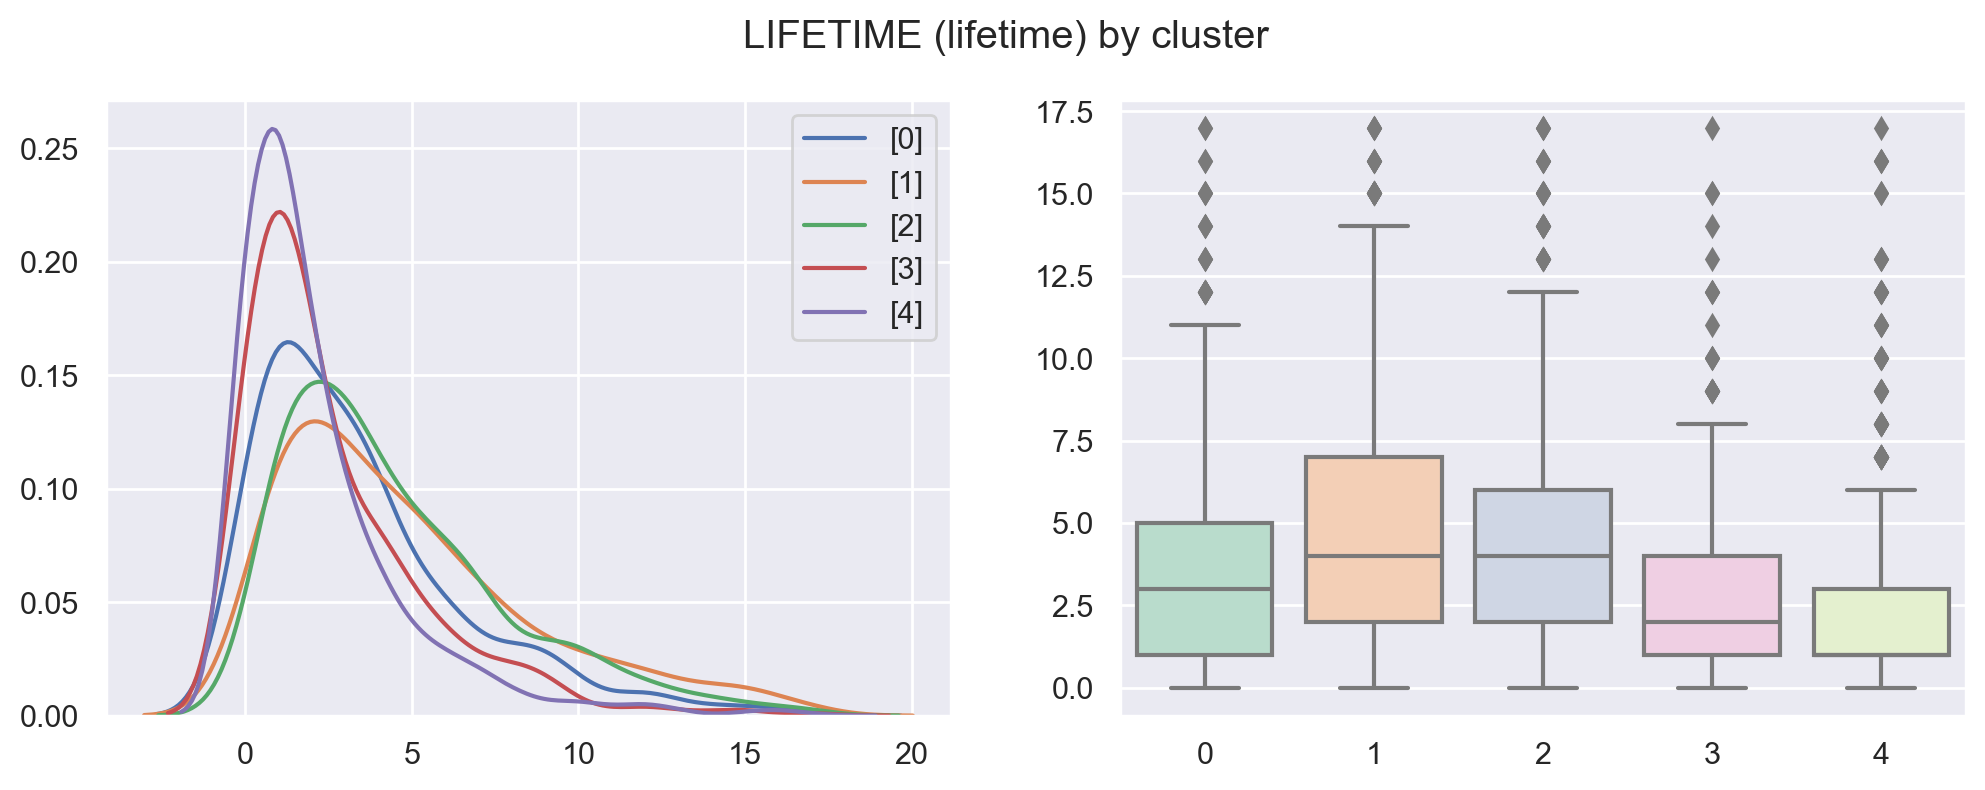

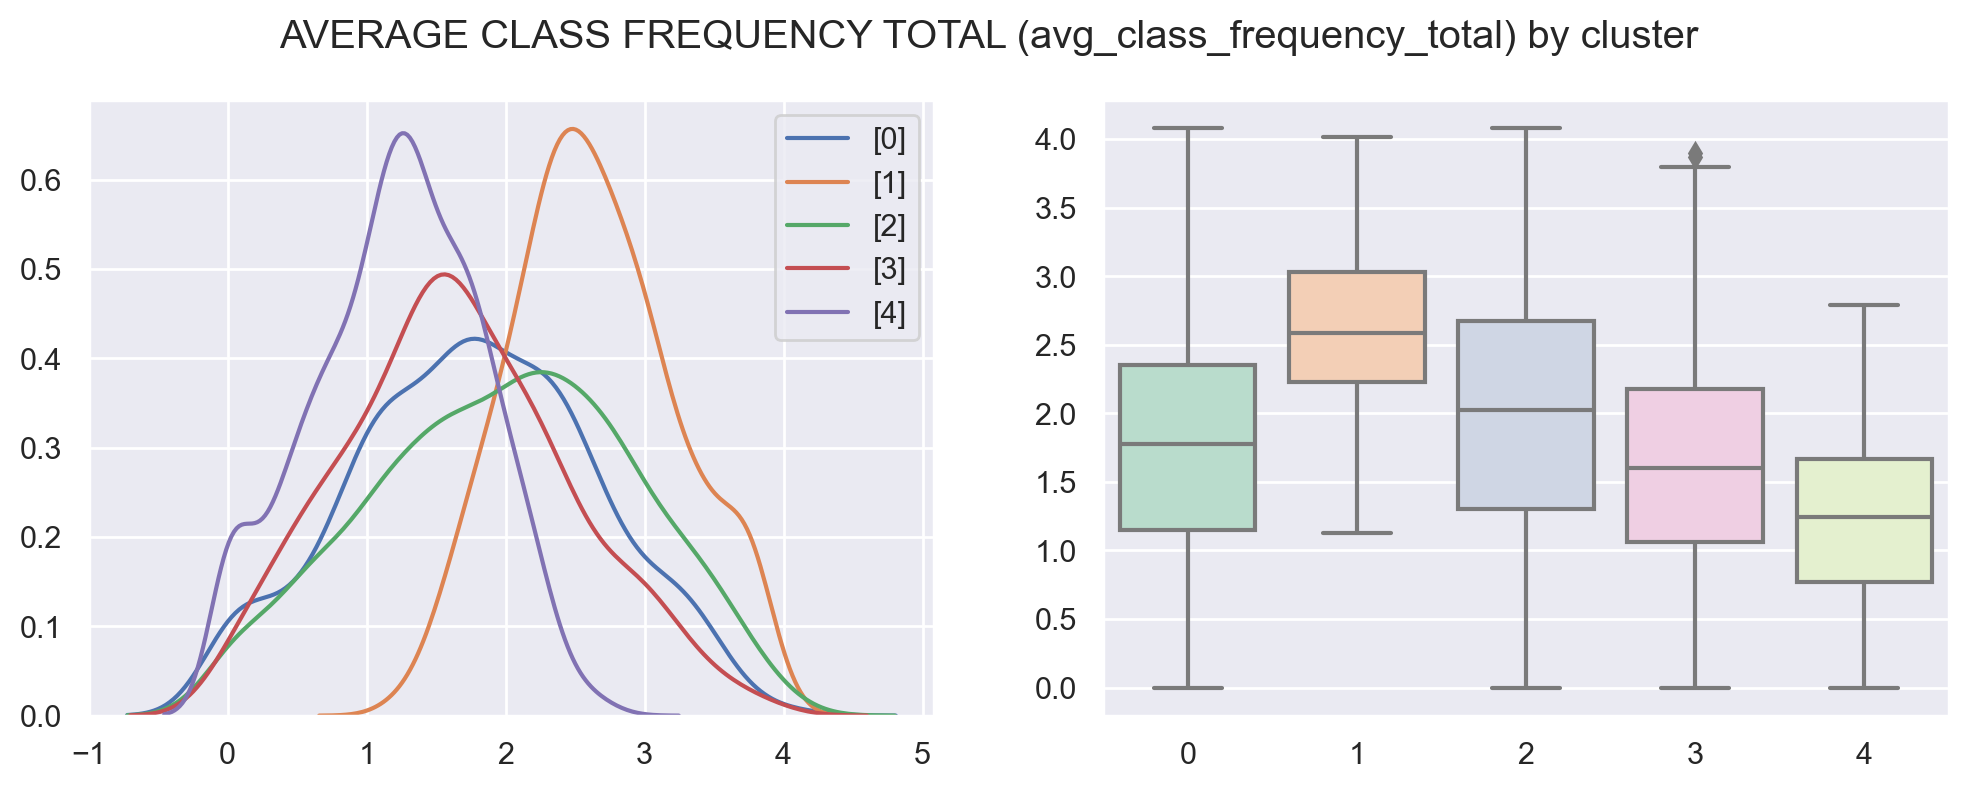

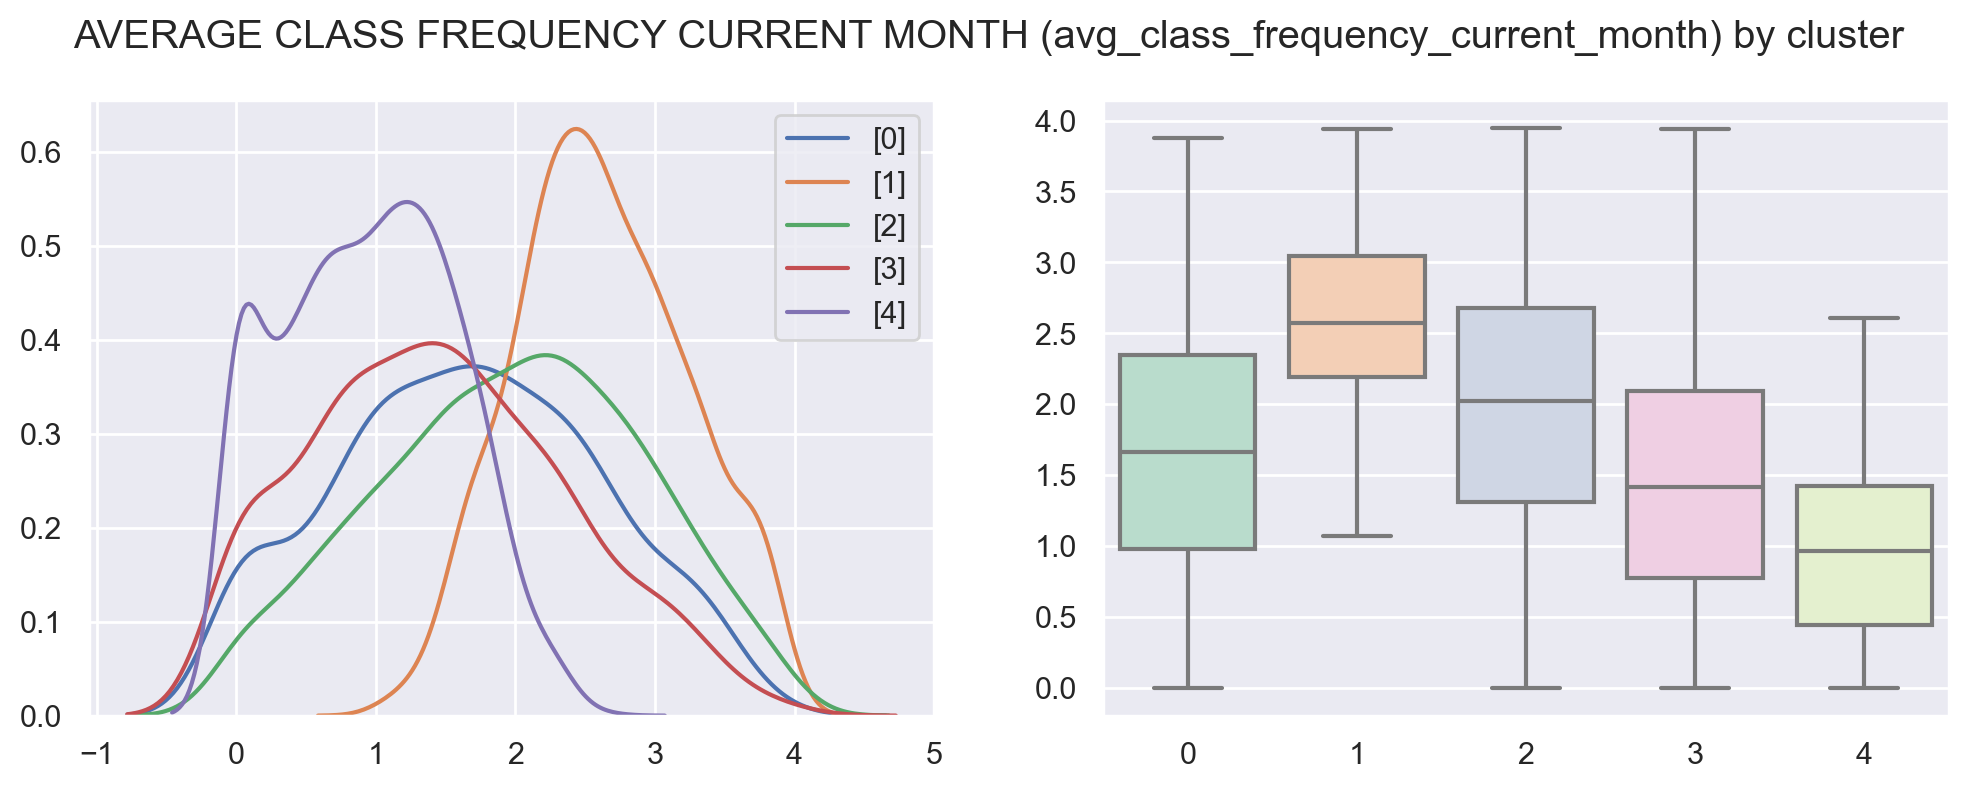

In [27]:
for index, row in numeric.iterrows():
    cluster_numeric_plots(data, row[0], row[1])

In general, nothing new.

Reliable clusters No. 1-2 are distinguished by older visitors who have annual or 6-month subscriptions, with a high degree of involvement (frequent and regular visits, additional money spending).

Clusters with high withdrawal (No. 3-4) consist of clients with monthly subscriptions, with a low degree of involvement.

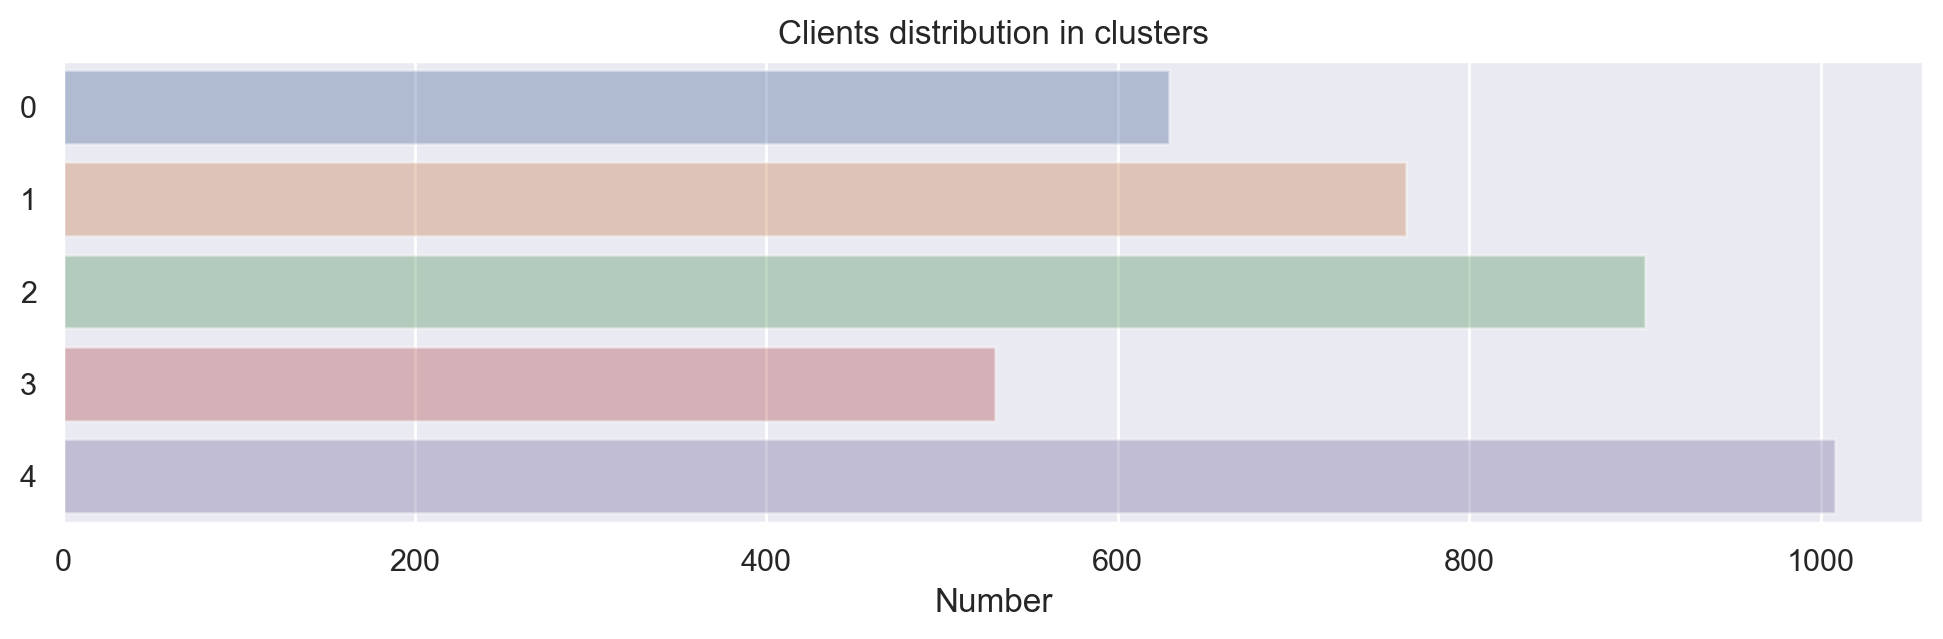

In [28]:
fig, ax = plt.subplots(figsize = (12, 3))
ax = sns.barplot(y='index', 
                 x='cluster_km', 
                 data=data.cluster_km.value_counts().reset_index(), 
                 alpha=0.4, orient='h')
ax.set_title('Clients distribution in clusters')
ax.set_xlabel('Number') 
ax.set_ylabel('') 
plt.show()

## Conclusions and recommendations

Based on data we can make following conclusions:

1. Characteristics that have the greatest impact on outflow (in descending order of importance):

 - *lifetime* ;
 - average frequency of visits to the club for the last month *avg_class_frequency_current_month*;
 - *age*;
 - term of the current subscription *contract_period*;
 - number of months before the expiration of the subscription *month_to_end_contract*.
 
2. We divided all customers into three distinct groups:

- those who have a high probability of getting into the withrowal;
- those who will definitely continue to attend the fitness club;
- those who can potentially join both the first and the second group;

3. For the convenience of analysis, we have devided clients into five clusters in order to identify pairs of the "high-quality-reliable" type with the same categorical characteristics.

In [35]:
data.groupby('cluster_km').mean().T

cluster_km,0,1,2,3,4
near_location,1.00,0.98,0.94,0.00,1.00
partner,0.84,0.23,0.74,0.47,0.25
promo_friends,1.00,0.06,0.49,0.08,0.03
contract_period,3.16,2.64,11.87,2.17,1.94
group_visits,0.45,0.46,0.55,0.21,0.32
age,29.21,30.02,29.88,28.45,28.10
avg_additional_charges_total,141.23,155.40,160.59,129.77,127.42
month_to_end_contract,2.92,2.44,10.88,2.04,1.87
lifetime,3.50,4.83,4.52,2.60,2.18
avg_class_frequency_total,1.77,2.63,1.98,1.65,1.21


Clusters No. 3-4 represent the **first group** of clients (with a high share of churn). They are characterized by low indicators of all characteristics: short life cycle, sharp decline in the number of visits in the current month compared to the previous one. We can assume that people tried (for the company or because of the proximity of the location) and did not get involved.

The **second group** is characterized by representatives of clusters No. 1-2, i.e. they live or work nearby, have high indicators among quantitative characteristics: long life cycle, the duration of the subscription period and the absence of difference between the frequency of visits for the entire period and for the reporting month.

The **third group** is the target group for us (cluster No. 0). The clients of this nominal group need to be additionally motivated first of all. On the one hand, its representatives take advantage of the proximity of the location and use a discount (an employee of a partner company or came for a promo campaign), visit the sportclub not for the first month, but for 3 or more. At the same time, the average number of visits per week begins to sink.

4. according to categorical characteristics, cluster No. 0 is similar to reliable cluster No. 2, therefore, as a recommendation, a proposal is put forward to stimulate quantitative features to indicators characteristic of cluster No. 2 (first of all, the availability of a long-term subscription).
   As likely marketing actions, customers may be offered:
   - additional discounts for employees of partner companies when buying an annual subscription;
   - motivational e-msails;

5. additionally, we can work with cluster No. 3 (it has similarities with cluster No. 1).

   As a likely motivating action can be offered:

   - discounts for regular visits;
   - discounts for group classes;
   - an additional month as a gift for regular visits from 2 times a week during the month.